In [1]:
# palette [3, 16]      -> [128] 256?
# image   [16, 64, 64] -> [128, 64, 64]

# shuffle palette

import torch
from torch import optim, nn
import numpy as np

import json
from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from IPython.display import clear_output

from UNet import ssim_loss
from models.vqvae import VQVAE

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

torch.Size([5, 386, 3, 64, 64])

torch.Size([4, 3, 72, 72])


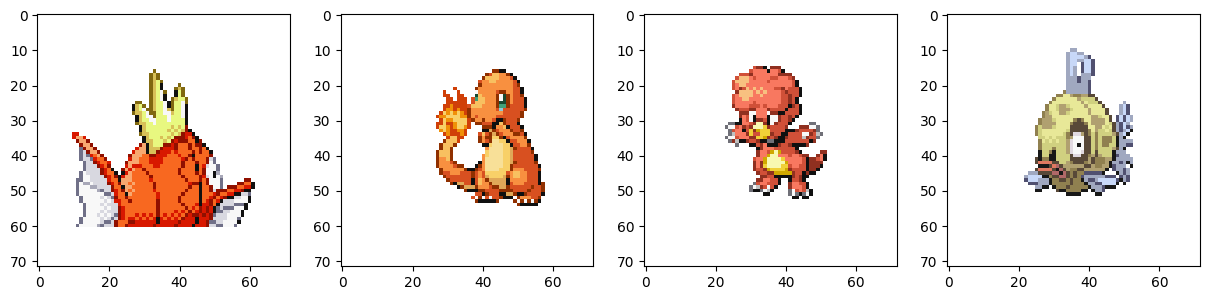

In [2]:
class Sobel():
    def __init__(self):
        self.weight = [[1, 0, -1], [0, 0, 0], [1, 0, -1]]
        self.weight = torch.tensor(self.weight, dtype=torch.float32)
        self.weight = self.weight[None, None, :, :].expand(3, -1, -1, -1)

    def __call__(self, sample):
        return nn.functional.conv2d(sample, self.weight.to(sample.device), groups=3)
sobel = Sobel()

pos_transform = v2.Compose([
    v2.Pad(6, 1.0),
    v2.RandomCrop((64 + 6, 64 + 6)),
    v2.Pad(1, 1.0),
    #v2.RandomApply([v2.RandomAffine(0, (0, 0), (0.8, 1.4), 0, fill=1.0)], .2),
    #v2.RandomApply([v2.RandomRotation(360, fill=1.0)], .2),
    #Sobel(),
])
#col_transform = v2.Compose([
#    v2.RandomApply([v2.ColorJitter()], .3),
#    v2.RandomApply([v2.RandomChannelPermutation()], .3),
#    v2.RandomGrayscale(p = .3),
#])

bs = 4
source = torch.randint(0, 5, (bs,))
batch = torch.randperm(385)[:bs]
x0 = pimages[source, batch]
#x0 = torch.stack([col_transform(pos_transform(x)) for x in x0], dim=0)
x0 = torch.stack([pos_transform(x) for x in x0], dim=0)
print(x0.shape)

fig, axes = plt.subplots(1, 4, figsize=(15, 15))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [3]:
#https://www.researchgate.net/figure/The-Vision-Transformer-architecture-a-the-main-architecture-of-the-model-b-the_fig2_348947034
class Transformer(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_dim)
        self.mha = nn.MultiheadAttention(emb_dim, num_heads=2, batch_first=True) ##2?

        self.ln2 = nn.LayerNorm(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 4 * emb_dim),
            nn.GELU(),
            nn.Linear(4 * emb_dim, emb_dim),
            #nn.Dropout(0.1),
        )

    def forward(self, x):
        x_ln = self.ln1(x)
        att, _ = self.mha(x_ln, x_ln, x_ln)
        
        att = self.ln2(att + x)
        return self.mlp(att) + att

In [4]:
#https://medium.com/@14prakash/masked-autoencoders-9e0f7a4a2585
class MyMAE(nn.Module):
    def __init__(self, img_size, patch_size, emb_dim):
        super().__init__()
        assert img_size % patch_size == 0

        self.emb_dim = emb_dim
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (self.img_size // self.patch_size) ** 2
        self.masked_size = int(0.75 * self.num_patches)

        self.patch_embedding = nn.Conv2d(3, self.emb_dim, 
                                         kernel_size=patch_size, 
                                         stride=patch_size,
                                         bias=True) #?

        self.pos_embedding = nn.Parameter(torch.zeros(self.num_patches, self.emb_dim), requires_grad=False)
        
        self.encoder = nn.Sequential(*[Transformer(self.emb_dim) for i in range(16)])
        self.decoder = nn.Sequential(*[Transformer(self.emb_dim) for i in range(2)])

        self.decoder_emb_dim = self.emb_dim
        self.decoder_emb = nn.Linear(self.emb_dim, self.decoder_emb_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, self.decoder_emb_dim))
        torch.nn.init.normal_(self.mask_token, std=.02)

        self.decoder_pos_emb = nn.Parameter(torch.zeros(self.num_patches, self.decoder_emb_dim))

        self.img_recov = nn.Linear(self.decoder_emb_dim, 3 * (self.patch_size ** 2), bias=True)
        

    def forward(self, x):
        bs, _, _, _ = x.shape
        device = x.device

        patches = self.patch_embedding(x)
        patches = patches.flatten(2, 3).transpose(1, 2)

        mask = torch.randperm(self.num_patches, device=device) #img size independent?
        mask = mask[:-self.masked_size]
        masked = patches[:, mask, :]

        pos_emb = self.pos_embedding[mask, :]
        tokens = masked + pos_emb[None, ...]
        features = self.encoder(tokens)

        ###### bottleneck

        tokens = self.mask_token.repeat(bs, self.num_patches, 1)
        tokens[:, mask, :] = self.decoder_emb(features)

        tokens = tokens + self.decoder_pos_emb
        features = self.decoder(tokens)

        image = self.img_recov(features)

        image = image.transpose(1,2)
        image = nn.functional.fold(image, 
                                   kernel_size=self.patch_size, 
                                   output_size=self.img_size, 
                                   stride=self.patch_size)
        
        return image

  0%|          | 0/200000 [00:00<?, ?it/s]

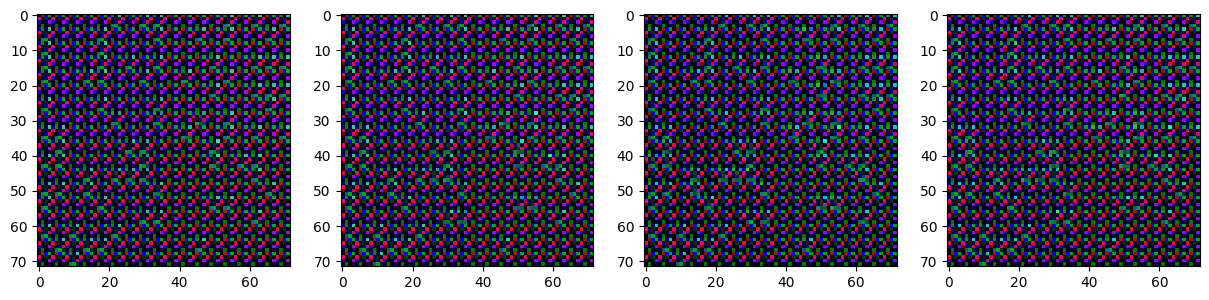

  1%|          | 2000/200000 [01:14<2:02:57, 26.84it/s]

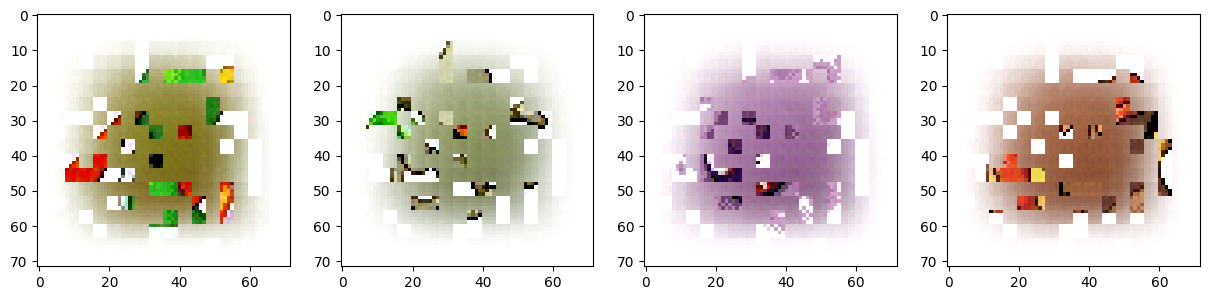

  2%|▏         | 4000/200000 [02:29<2:01:52, 26.80it/s]

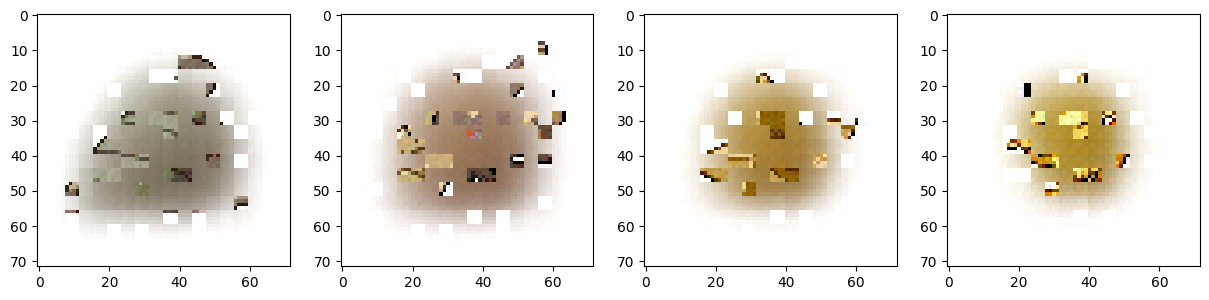

  3%|▎         | 6000/200000 [03:44<2:00:29, 26.83it/s]

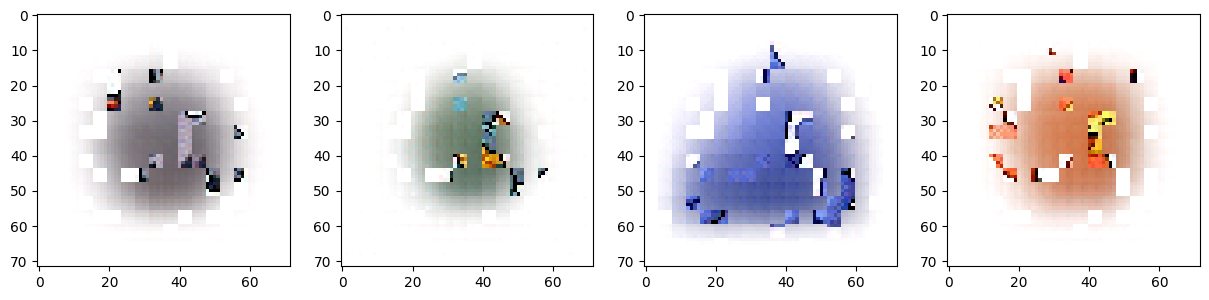

  4%|▍         | 8000/200000 [04:59<1:59:19, 26.82it/s]

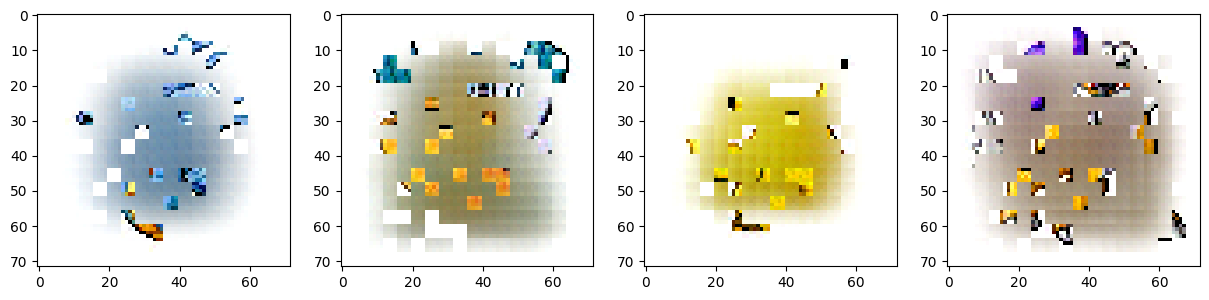

  5%|▌         | 10000/200000 [06:13<1:58:09, 26.80it/s]

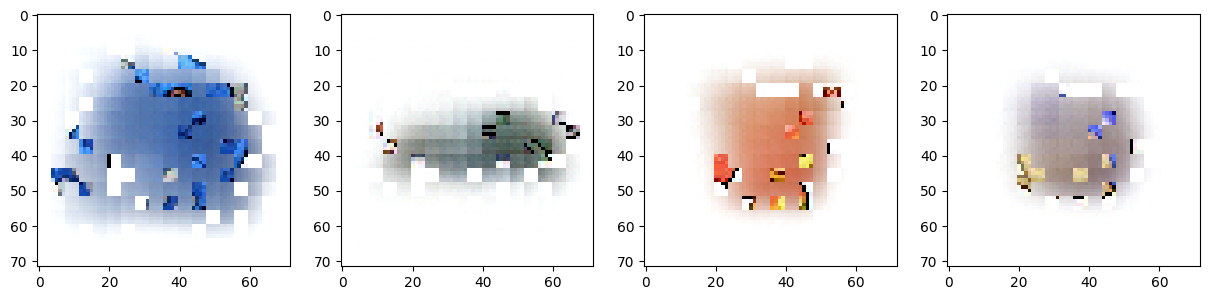

  6%|▌         | 12000/200000 [07:28<1:56:39, 26.86it/s]

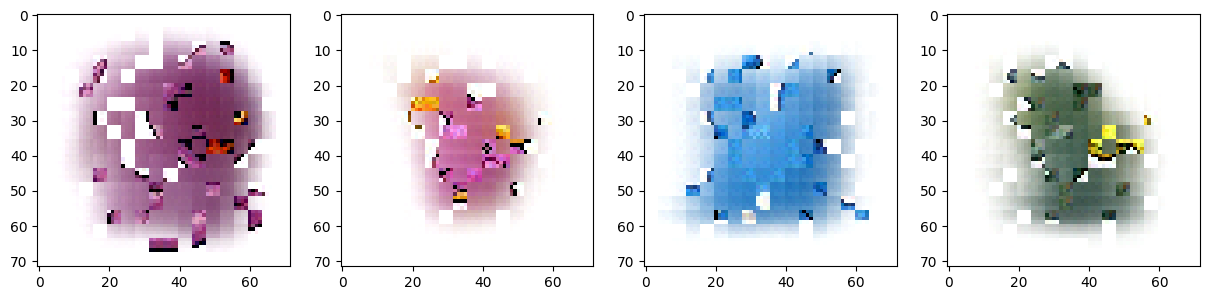

  7%|▋         | 14000/200000 [08:43<1:55:30, 26.84it/s]

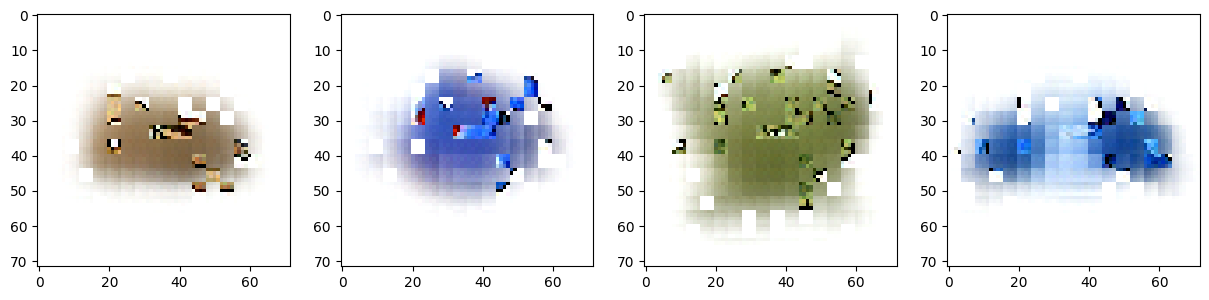

  8%|▊         | 16000/200000 [09:57<1:54:14, 26.84it/s]

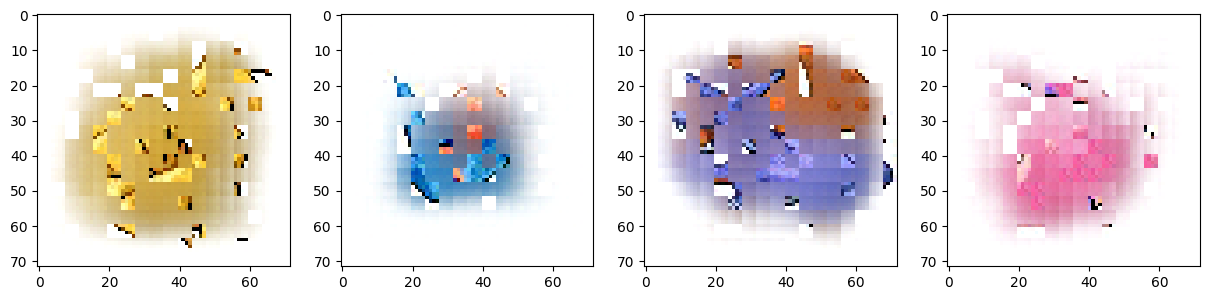

  9%|▉         | 18000/200000 [11:12<1:53:05, 26.82it/s]

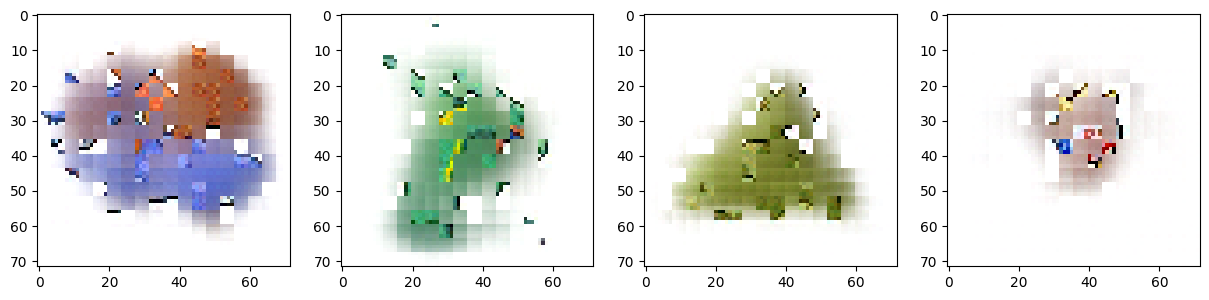

 10%|█         | 20000/200000 [12:27<1:51:52, 26.82it/s]

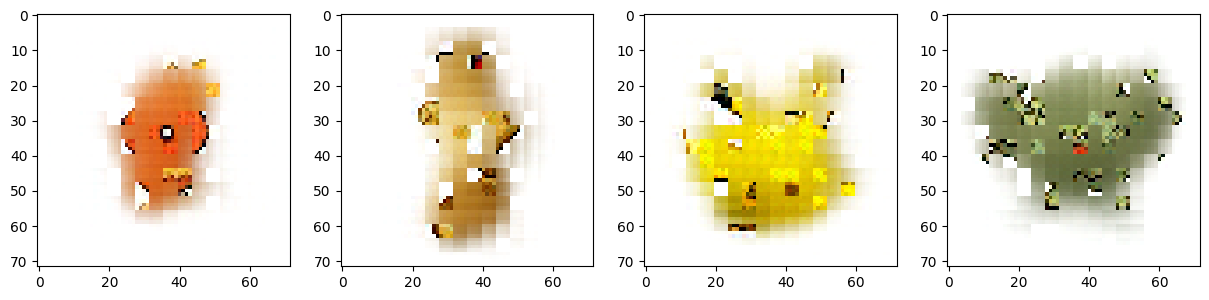

 11%|█         | 22000/200000 [13:41<1:50:34, 26.83it/s]

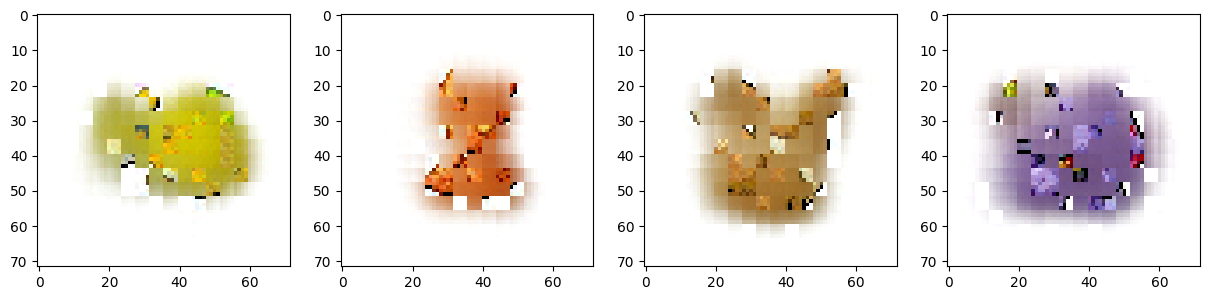

 12%|█▏        | 24000/200000 [14:56<1:49:20, 26.83it/s]

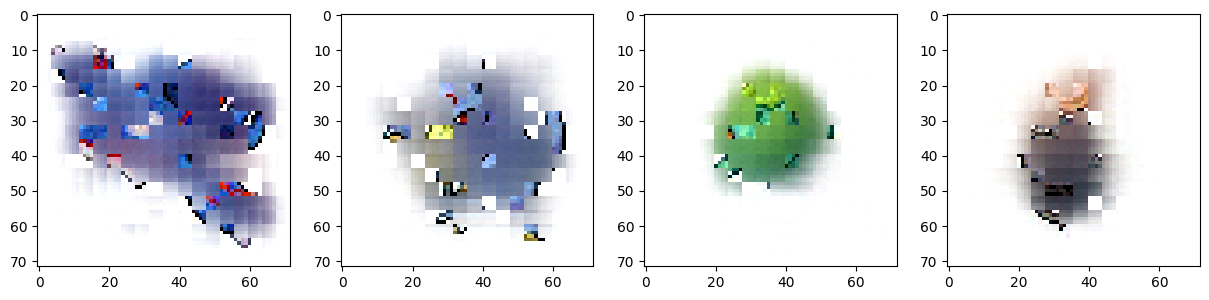

 13%|█▎        | 26000/200000 [16:11<1:48:07, 26.82it/s]

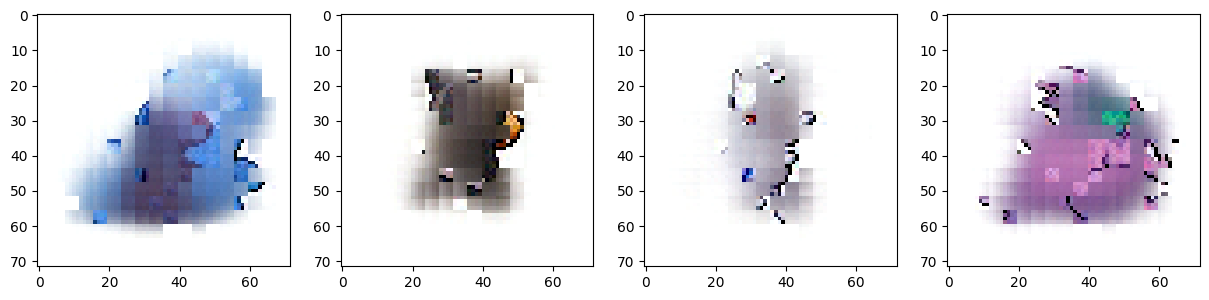

 14%|█▍        | 28000/200000 [17:26<1:46:48, 26.84it/s]

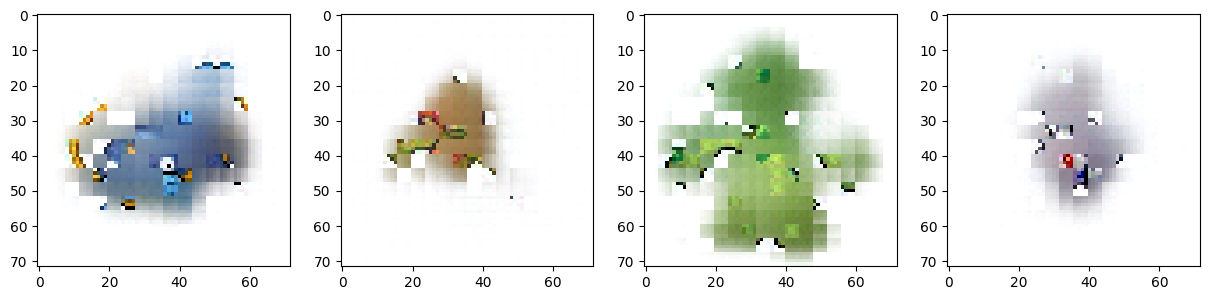

 15%|█▌        | 30000/200000 [18:40<1:45:33, 26.84it/s]

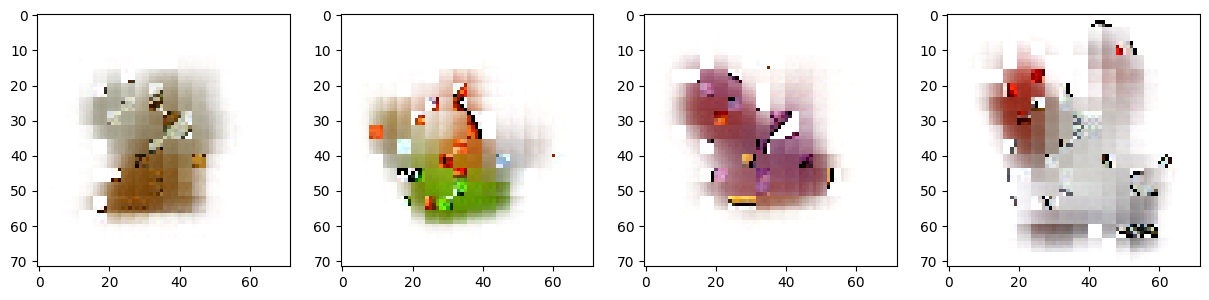

 16%|█▌        | 32000/200000 [19:55<1:44:23, 26.82it/s]

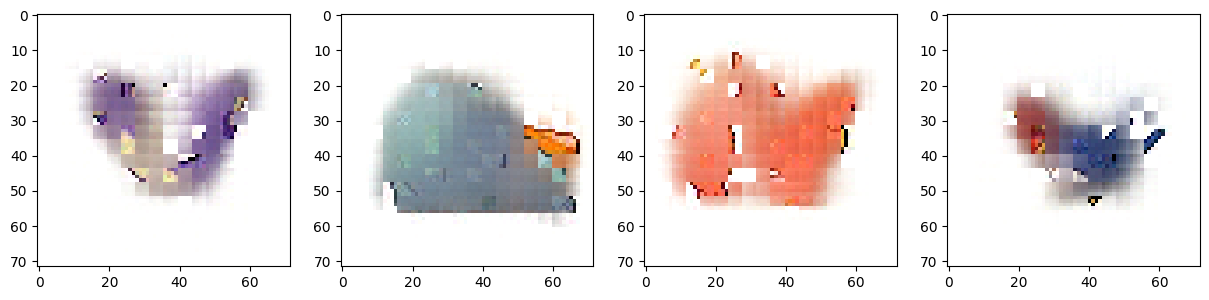

 17%|█▋        | 34000/200000 [21:10<1:43:08, 26.82it/s]

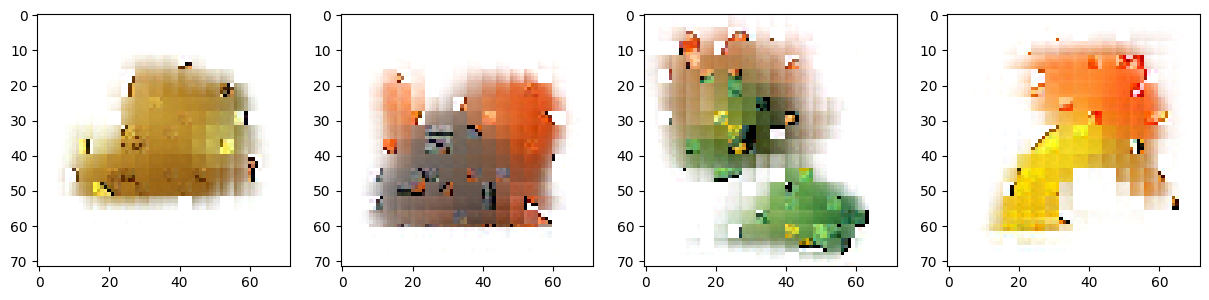

 18%|█▊        | 36000/200000 [22:24<1:41:50, 26.84it/s]

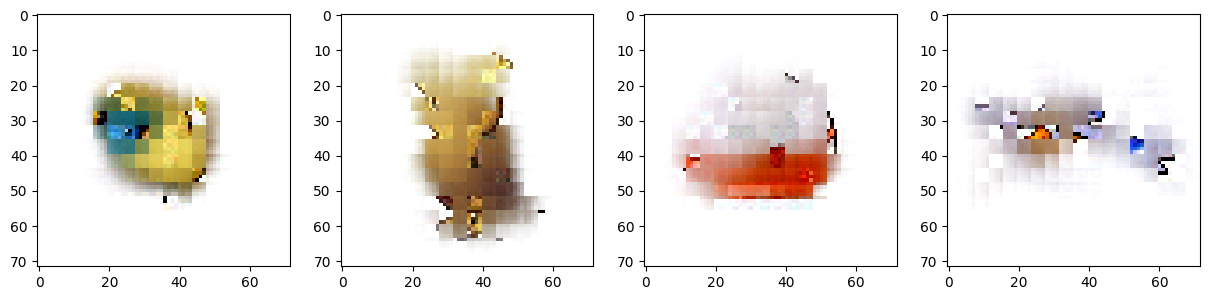

 19%|█▉        | 38000/200000 [23:39<1:40:37, 26.83it/s]

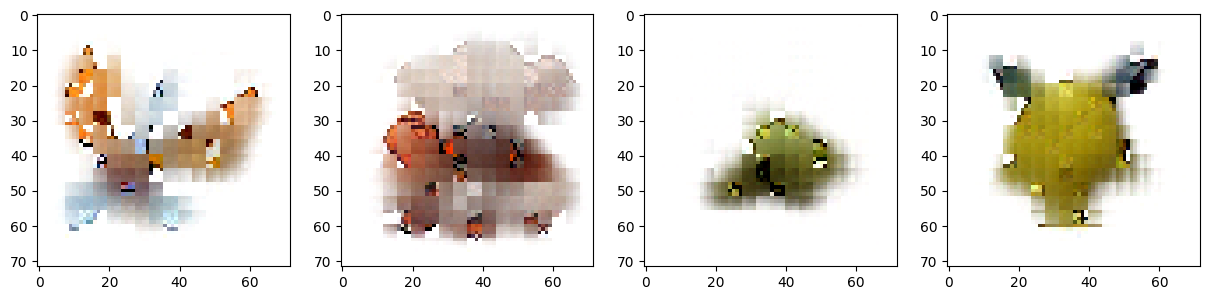

 20%|██        | 40000/200000 [24:54<1:39:10, 26.89it/s]

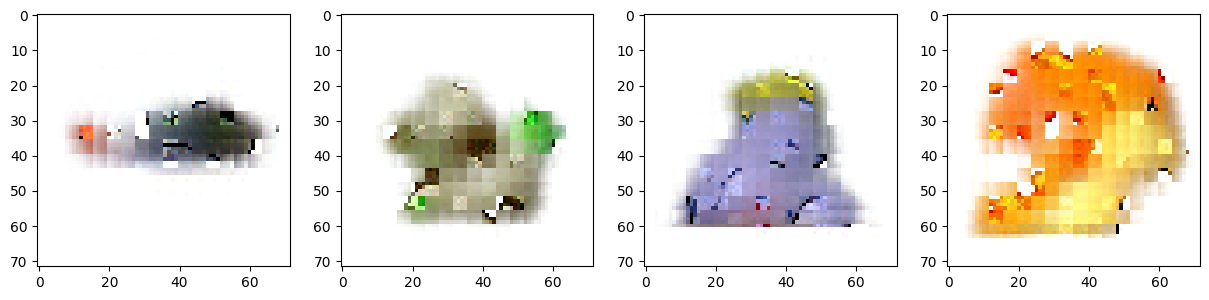

 21%|██        | 42000/200000 [26:08<1:38:05, 26.85it/s]

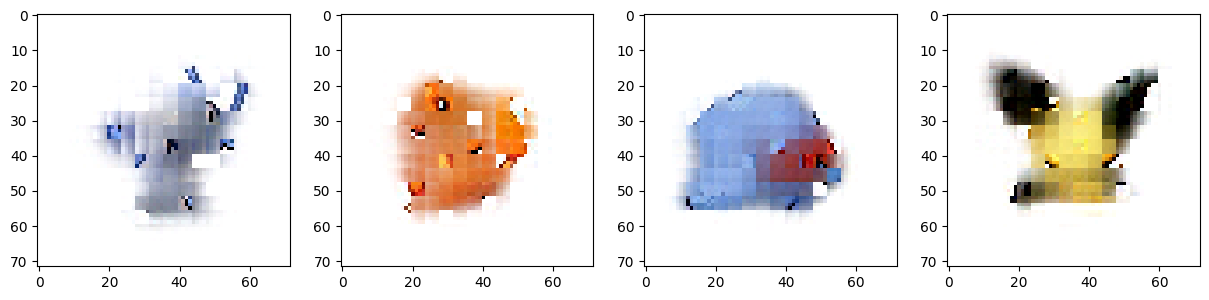

 22%|██▏       | 44000/200000 [27:23<1:36:55, 26.82it/s]

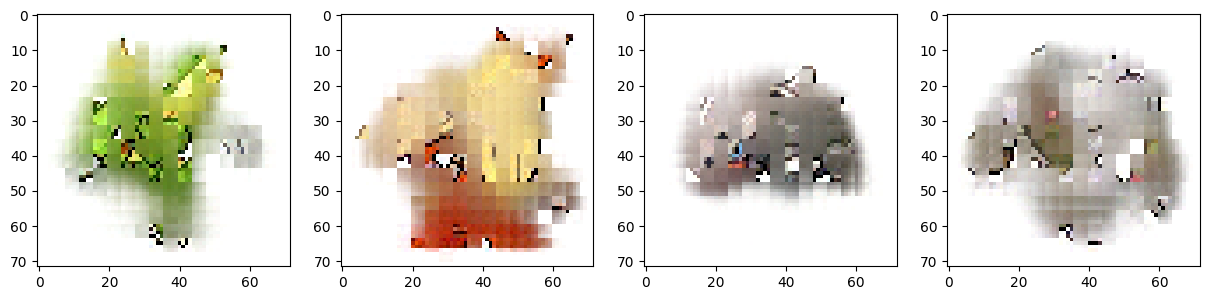

 23%|██▎       | 46000/200000 [28:38<1:35:43, 26.81it/s]

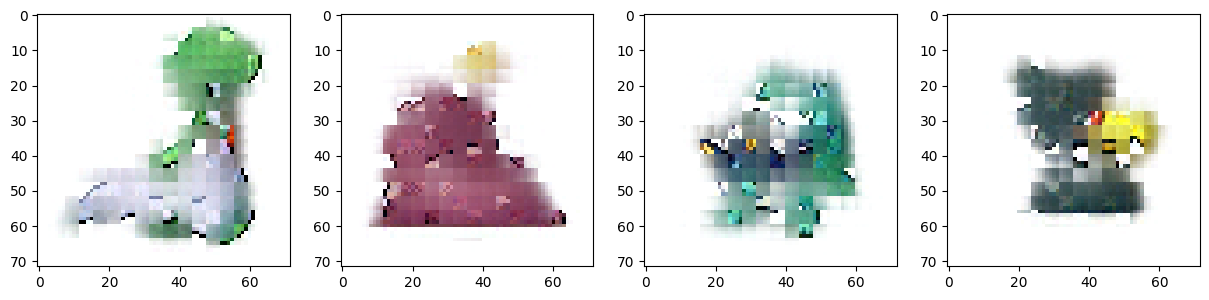

 24%|██▍       | 48000/200000 [29:52<1:34:27, 26.82it/s]

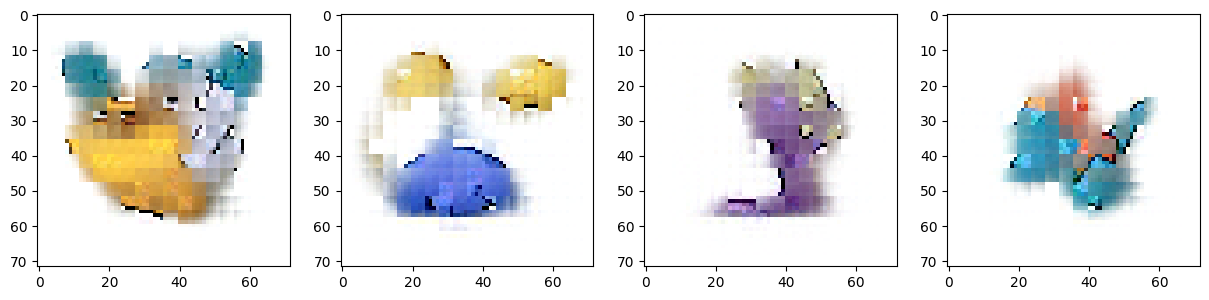

 25%|██▌       | 50000/200000 [31:07<1:33:12, 26.82it/s]

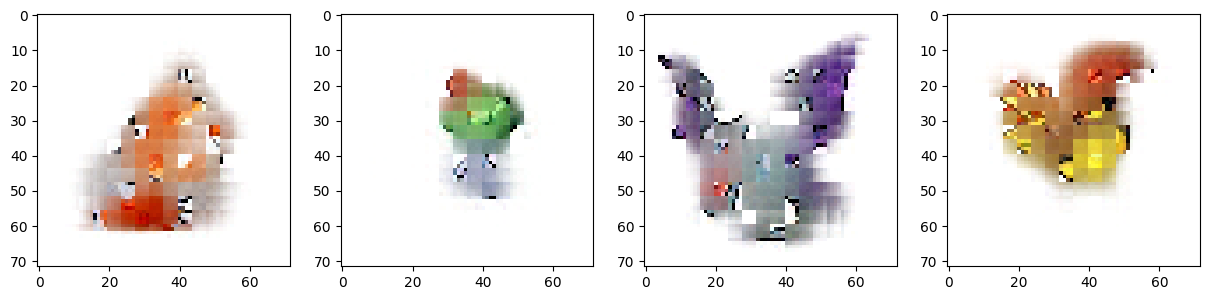

 26%|██▌       | 52000/200000 [32:22<1:31:51, 26.85it/s]

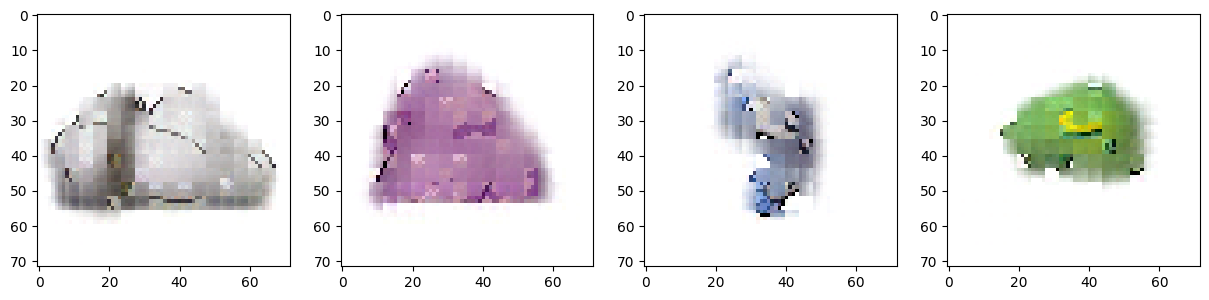

 27%|██▋       | 54000/200000 [33:36<1:30:42, 26.83it/s]

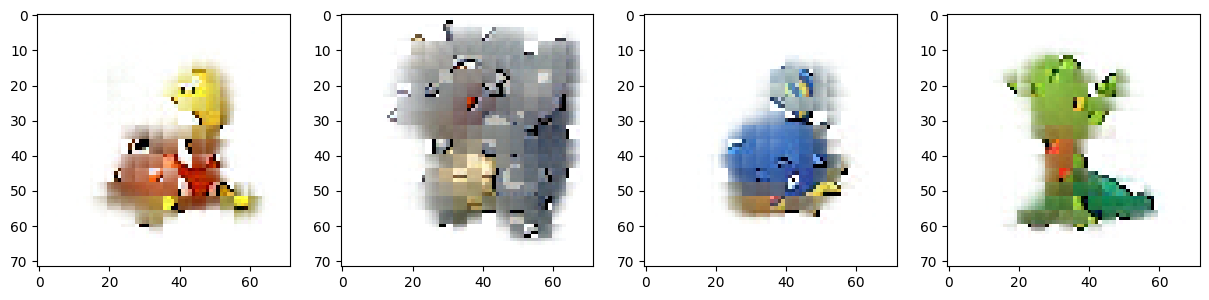

 28%|██▊       | 56000/200000 [34:51<1:29:30, 26.81it/s]

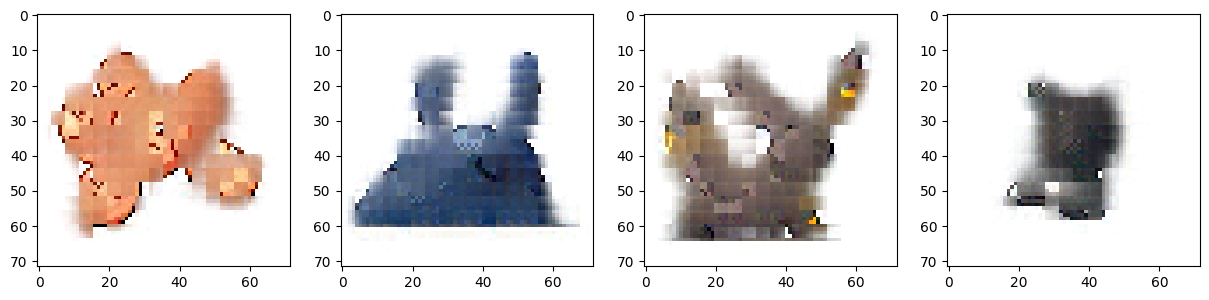

 29%|██▉       | 58000/200000 [36:06<1:28:13, 26.83it/s]

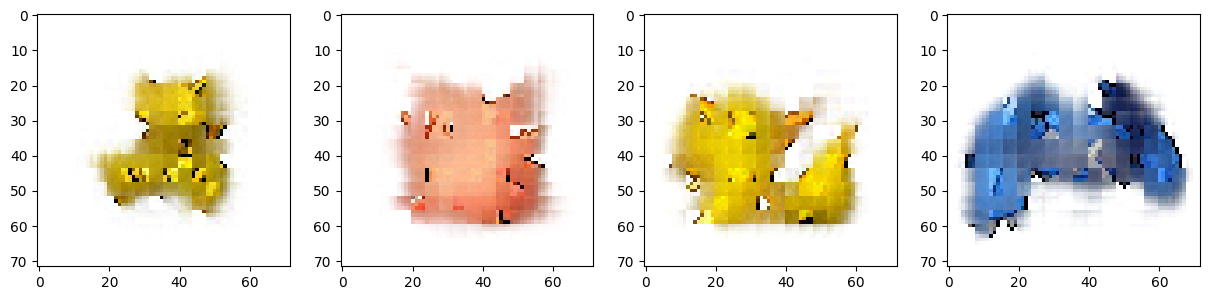

 30%|███       | 60000/200000 [37:21<1:27:03, 26.80it/s]

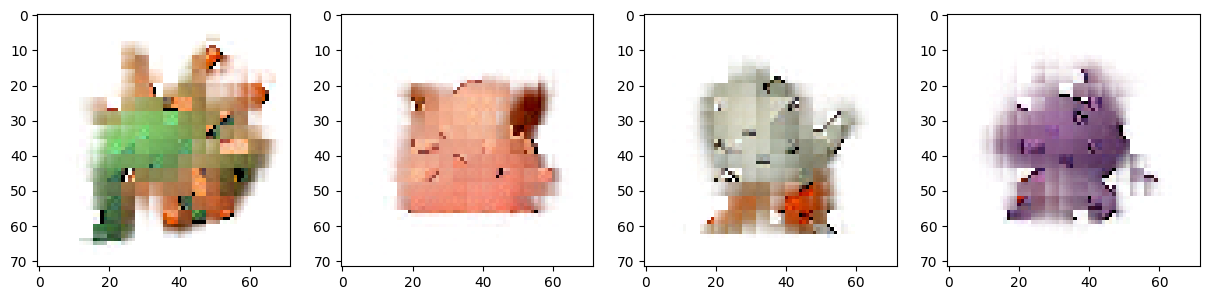

 31%|███       | 62000/200000 [38:35<1:25:50, 26.80it/s]

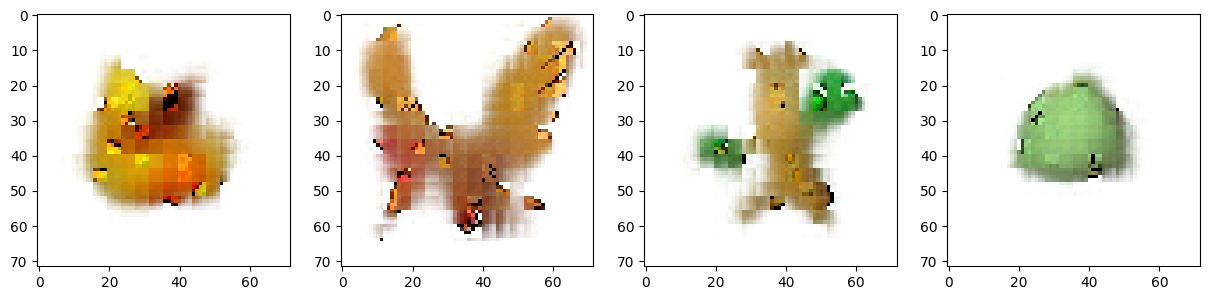

 32%|███▏      | 64000/200000 [39:50<1:24:27, 26.84it/s]

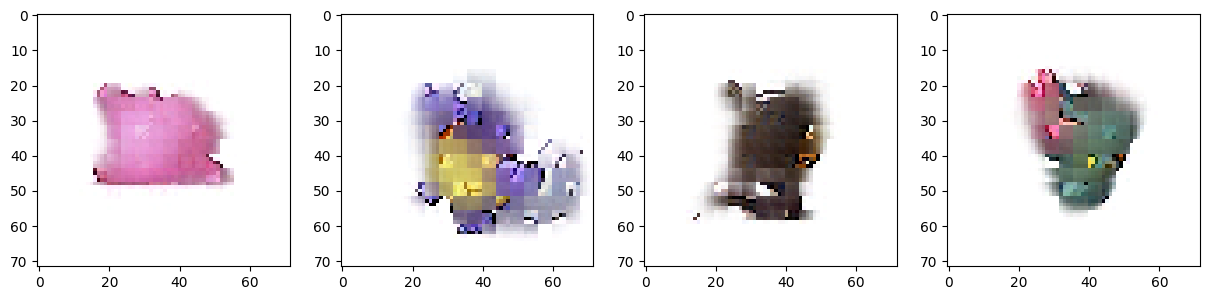

 33%|███▎      | 66000/200000 [41:05<1:23:12, 26.84it/s]

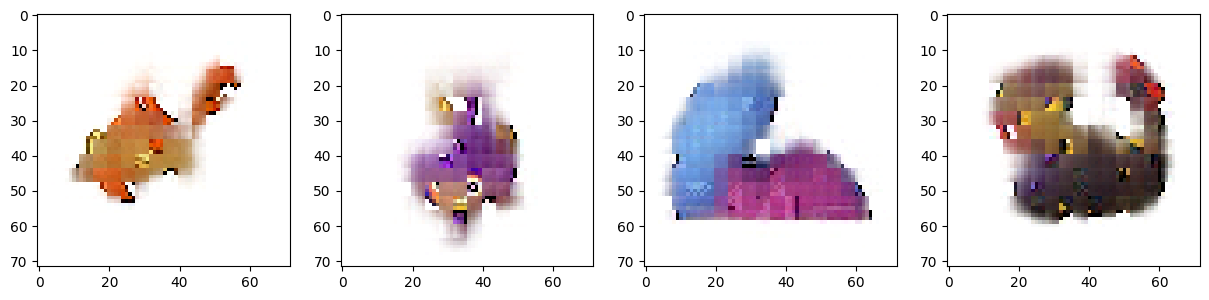

 34%|███▍      | 68000/200000 [42:20<1:22:05, 26.80it/s]

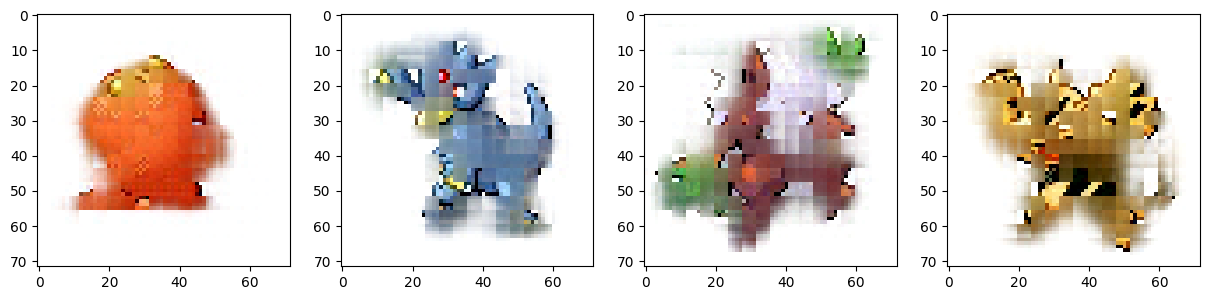

 35%|███▌      | 70000/200000 [43:34<1:20:38, 26.87it/s]

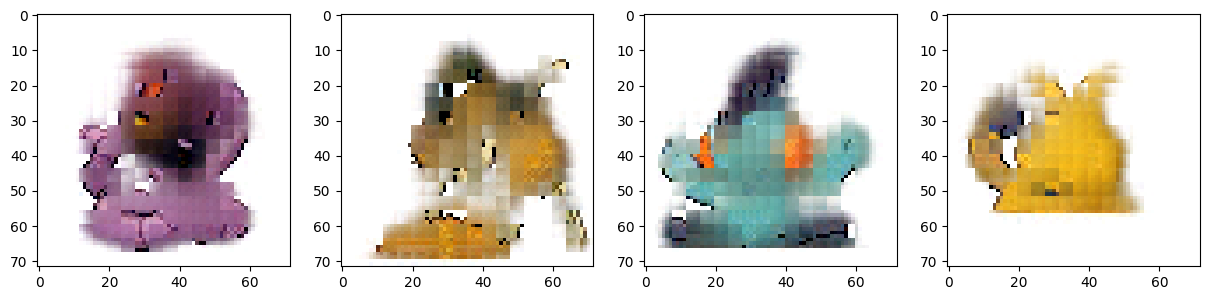

 36%|███▌      | 72000/200000 [44:49<1:19:34, 26.81it/s]

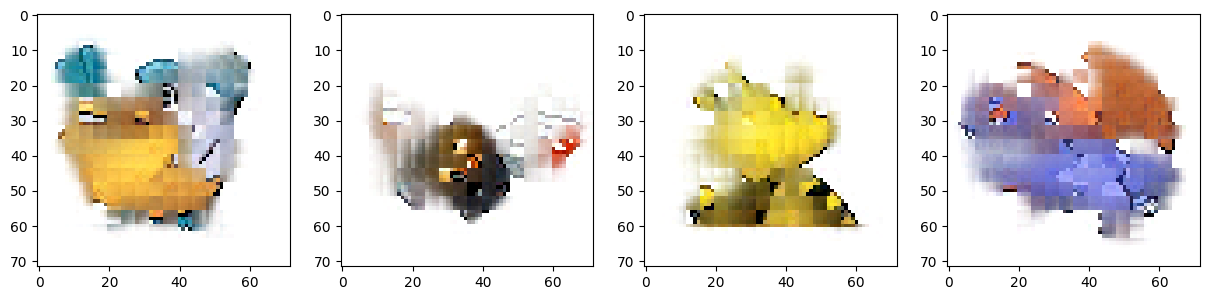

 37%|███▋      | 74000/200000 [46:04<1:18:12, 26.85it/s]

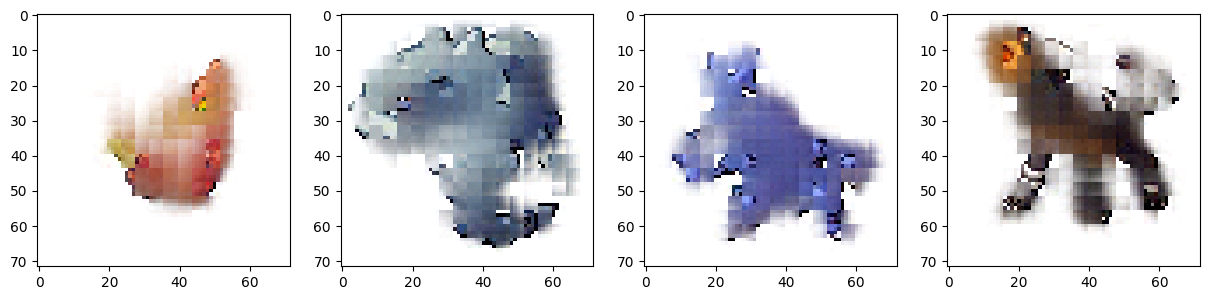

 38%|███▊      | 76000/200000 [47:18<1:17:07, 26.80it/s]

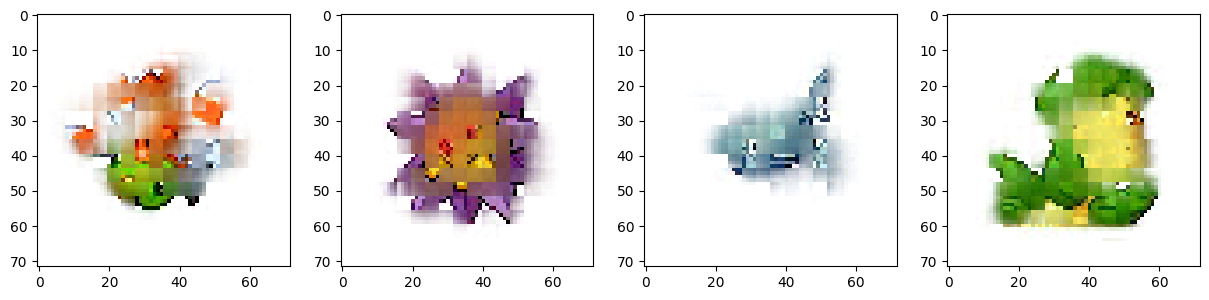

 39%|███▉      | 78000/200000 [48:33<1:15:49, 26.82it/s]

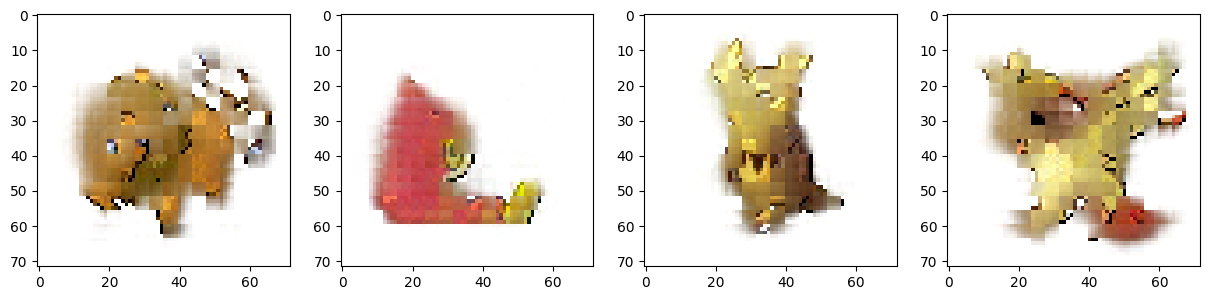

 40%|████      | 80000/200000 [49:48<1:14:33, 26.82it/s]

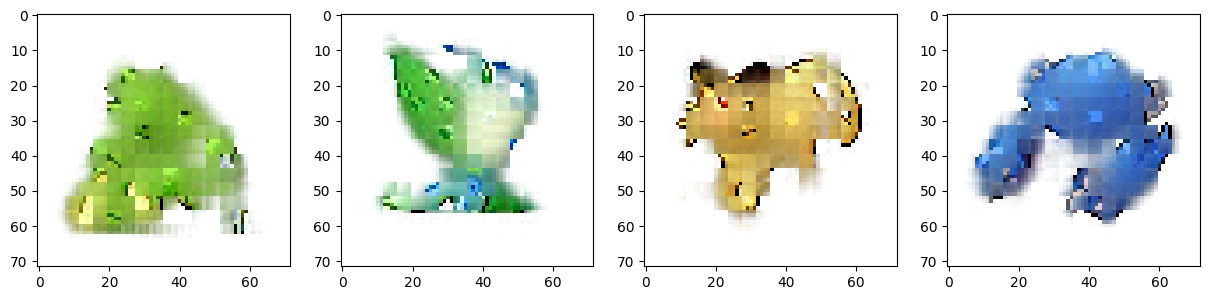

 41%|████      | 82000/200000 [51:03<1:13:18, 26.83it/s]

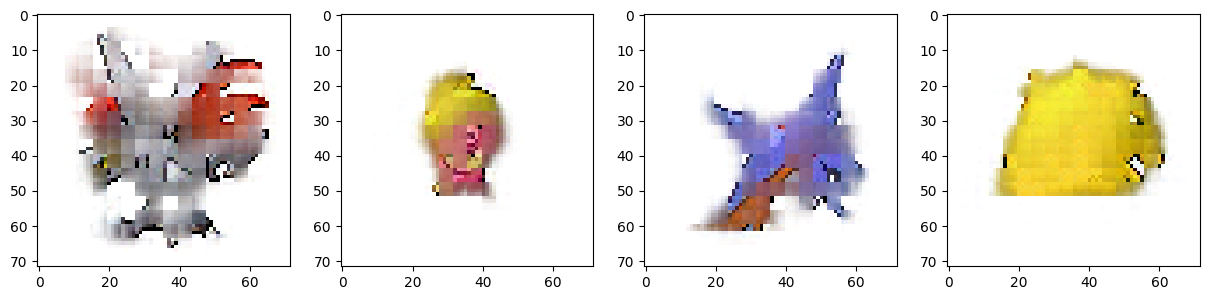

 42%|████▏     | 84000/200000 [52:17<1:12:03, 26.83it/s]

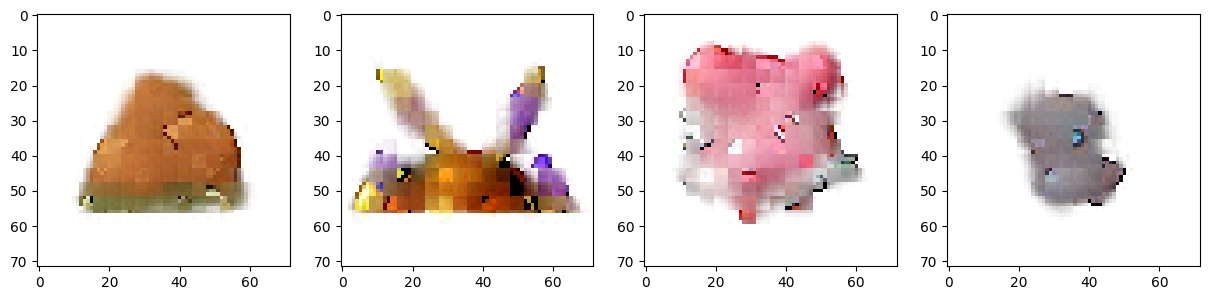

 43%|████▎     | 86000/200000 [53:32<1:10:47, 26.84it/s]

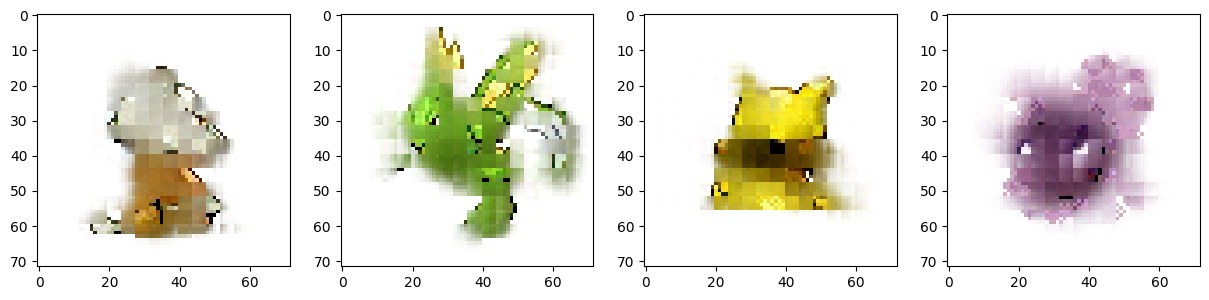

 44%|████▍     | 88000/200000 [54:47<1:09:24, 26.89it/s]

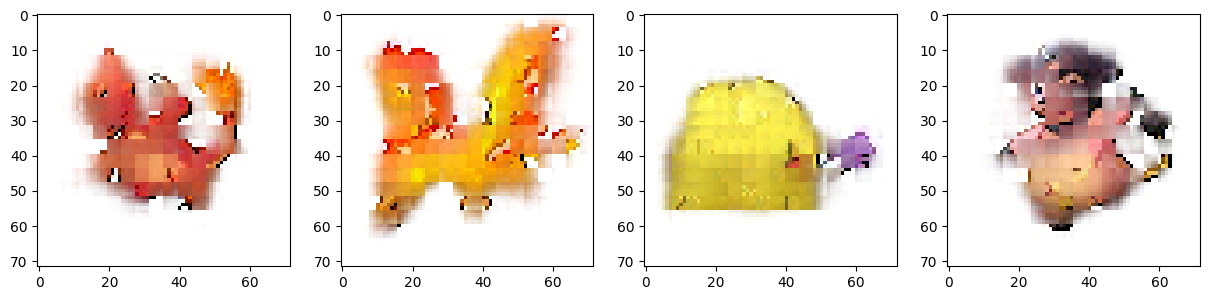

 45%|████▌     | 90000/200000 [56:01<1:08:21, 26.82it/s]

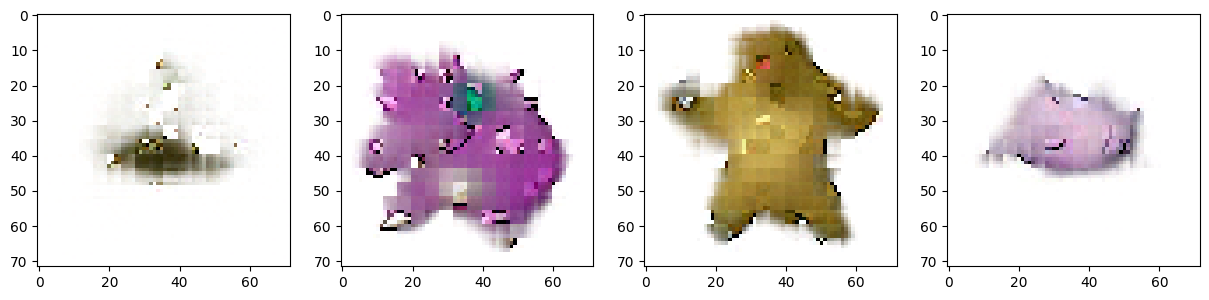

 46%|████▌     | 92000/200000 [57:16<1:07:09, 26.81it/s]

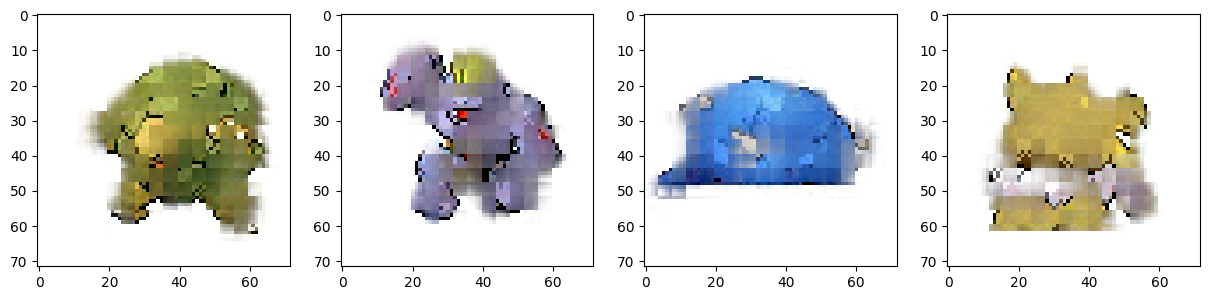

 47%|████▋     | 94000/200000 [58:31<1:05:58, 26.78it/s]

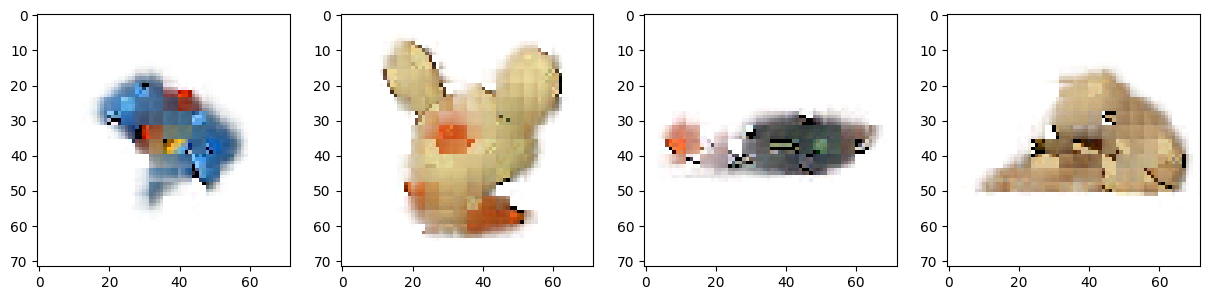

 48%|████▊     | 96000/200000 [59:46<1:04:39, 26.80it/s]

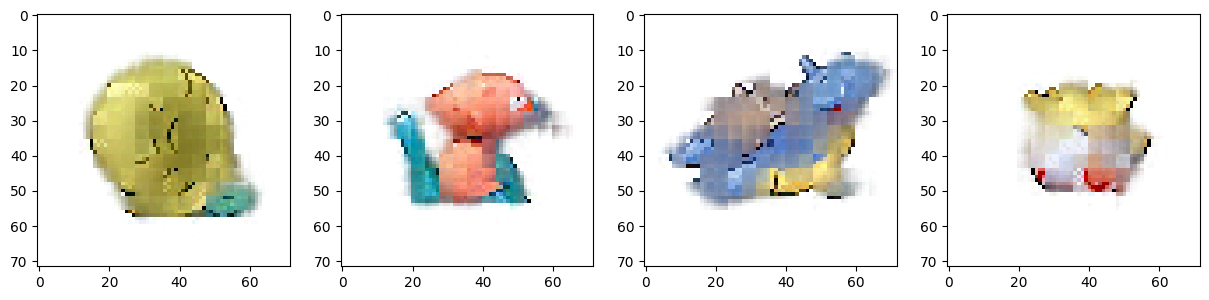

 49%|████▉     | 98000/200000 [1:01:00<1:03:26, 26.79it/s]

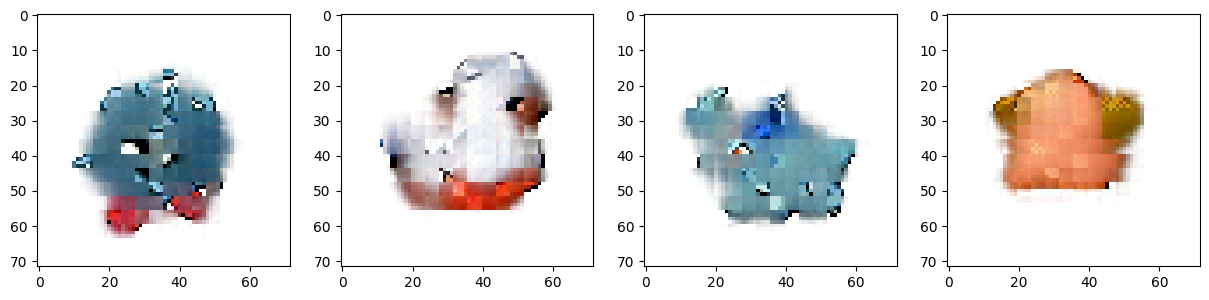

 50%|█████     | 100000/200000 [1:02:15<1:02:11, 26.80it/s]

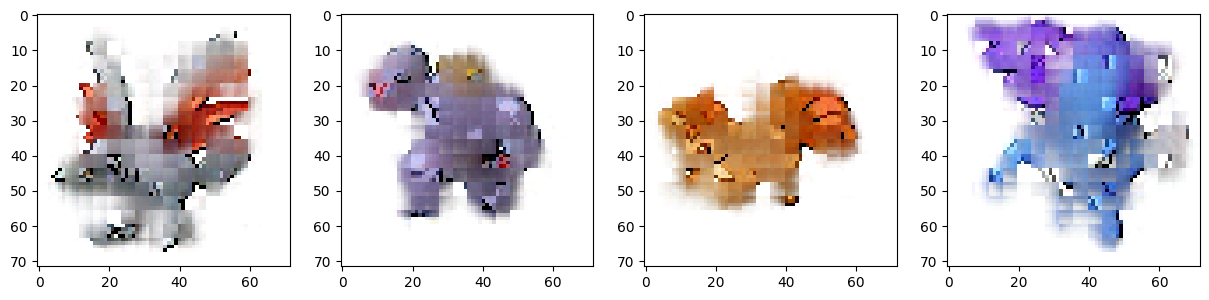

 51%|█████     | 102000/200000 [1:03:30<1:00:57, 26.80it/s]

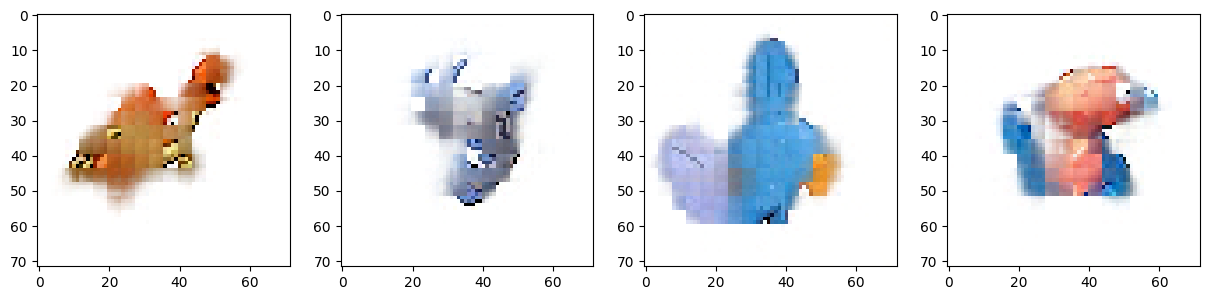

 52%|█████▏    | 104000/200000 [1:04:45<59:42, 26.80it/s]  

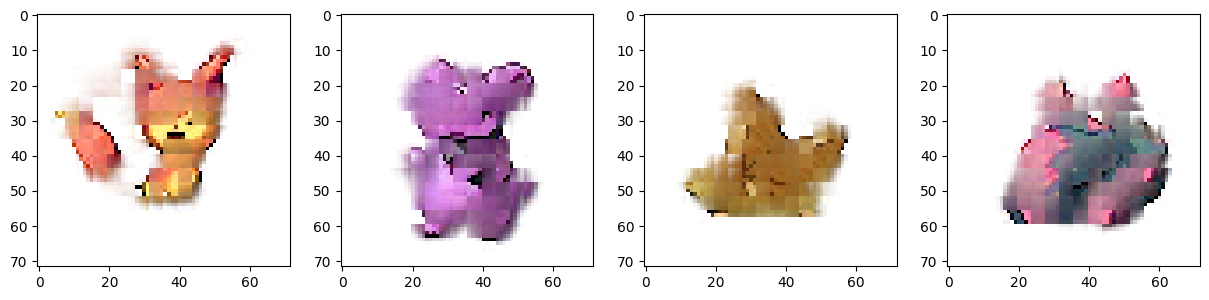

 53%|█████▎    | 106000/200000 [1:06:00<58:30, 26.78it/s]  

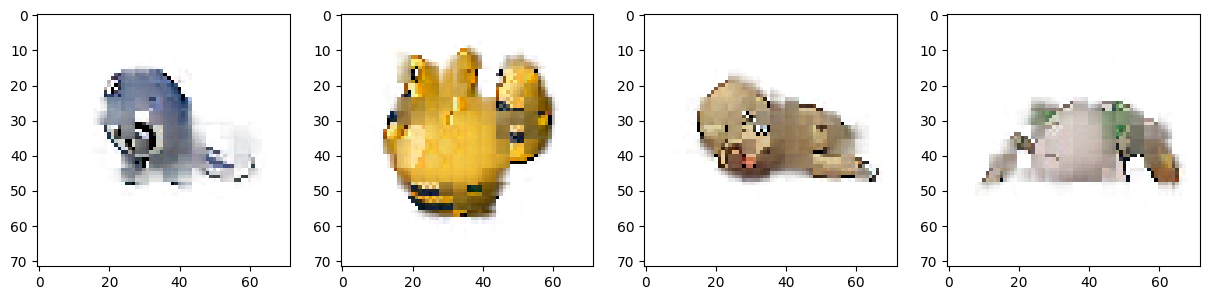

 54%|█████▍    | 108000/200000 [1:07:14<57:08, 26.83it/s]  

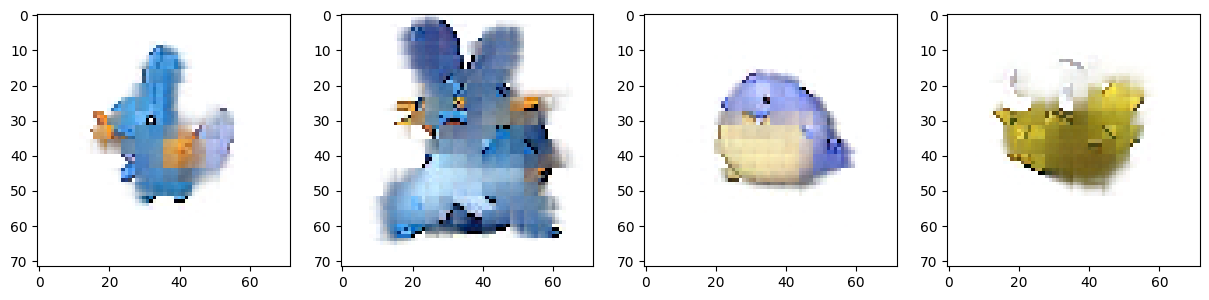

 55%|█████▌    | 110000/200000 [1:08:29<55:51, 26.86it/s]  

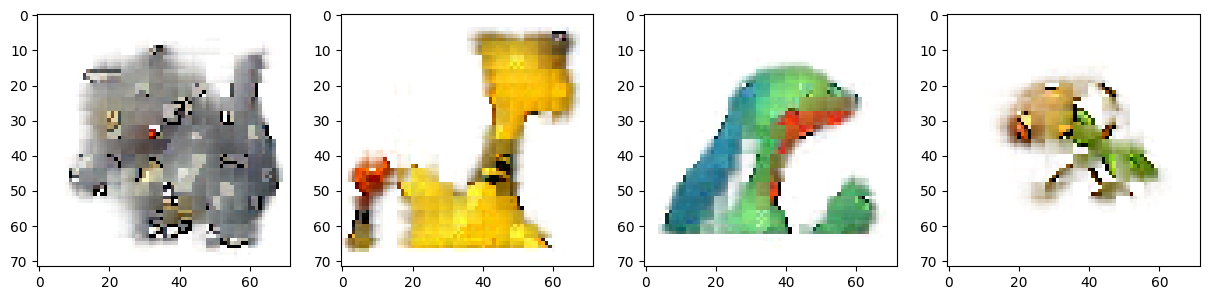

 56%|█████▌    | 112000/200000 [1:09:44<54:43, 26.80it/s]  

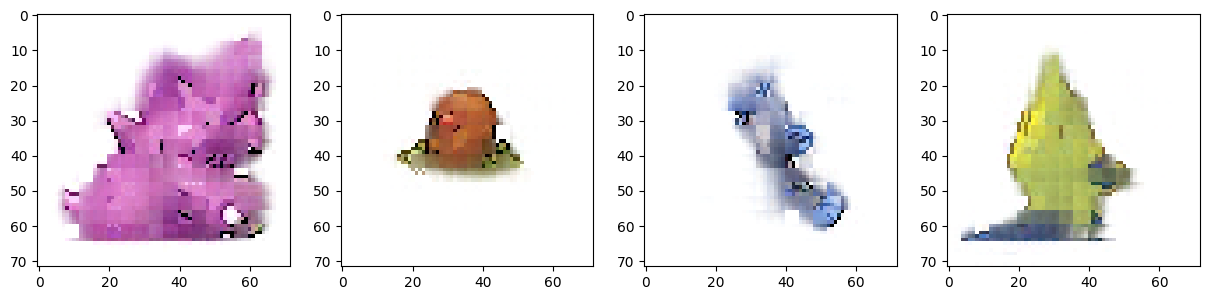

 57%|█████▋    | 114000/200000 [1:10:59<53:26, 26.82it/s]  

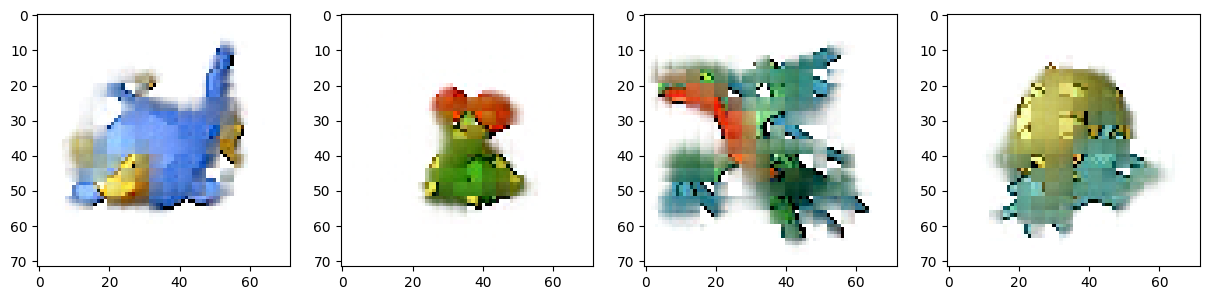

 58%|█████▊    | 116000/200000 [1:12:13<52:12, 26.82it/s]

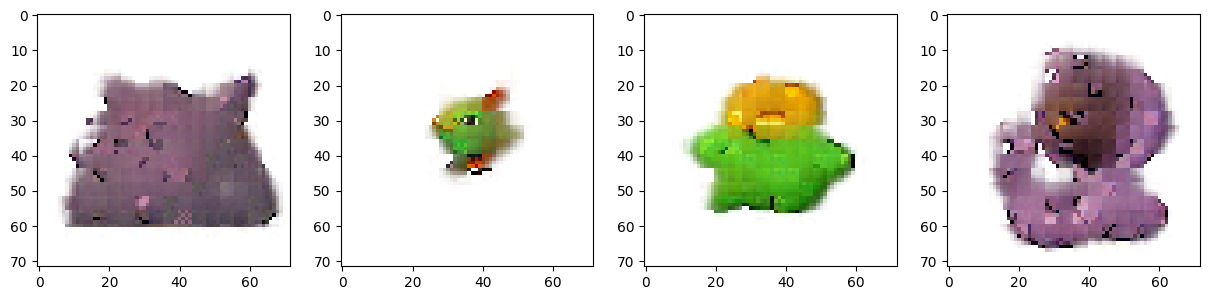

 59%|█████▉    | 118000/200000 [1:13:28<50:57, 26.82it/s]

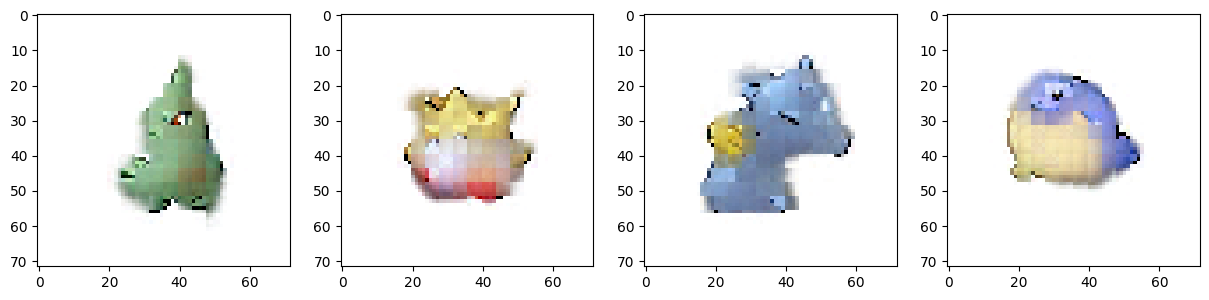

 60%|██████    | 120000/200000 [1:14:43<49:43, 26.82it/s]

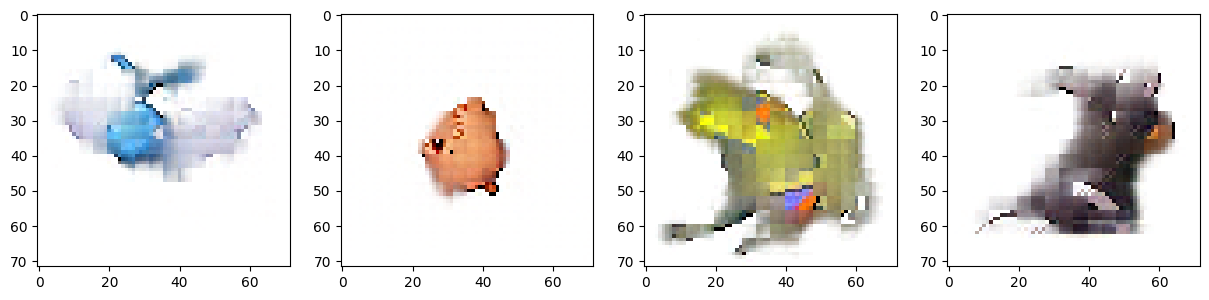

 61%|██████    | 122000/200000 [1:15:58<48:30, 26.80it/s]

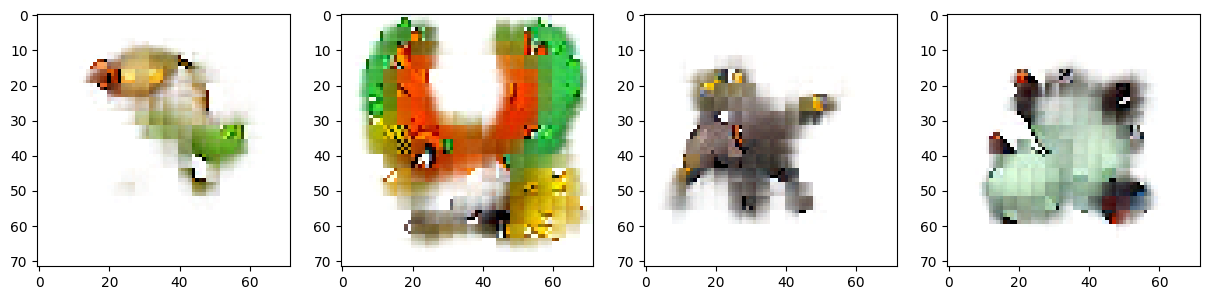

 62%|██████▏   | 124000/200000 [1:17:12<47:12, 26.83it/s]

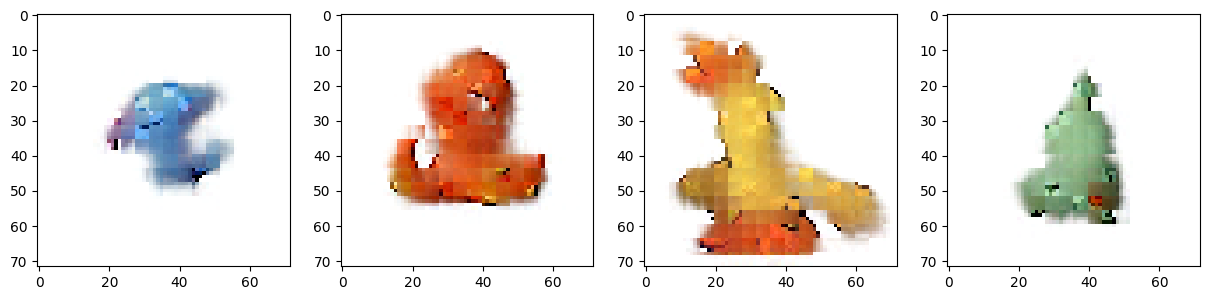

 63%|██████▎   | 126000/200000 [1:18:27<45:58, 26.82it/s]

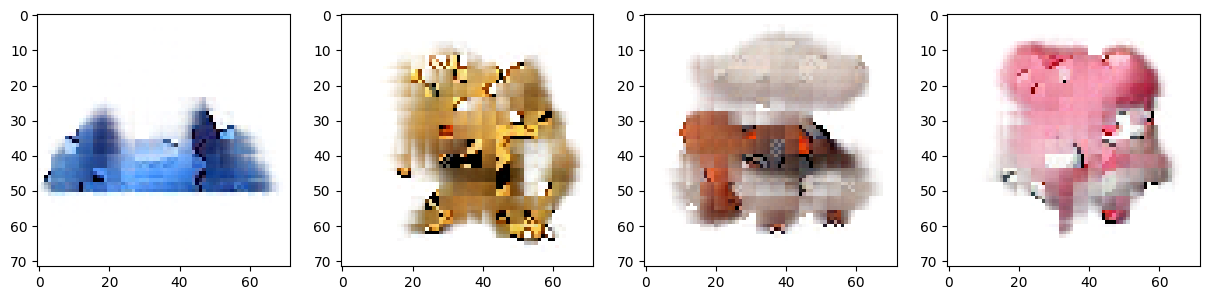

 64%|██████▍   | 128000/200000 [1:19:42<44:47, 26.79it/s]

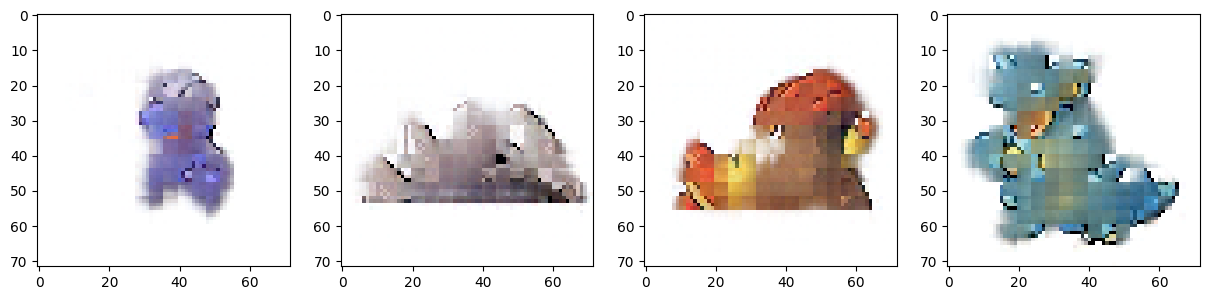

 65%|██████▌   | 130000/200000 [1:20:56<43:29, 26.82it/s]

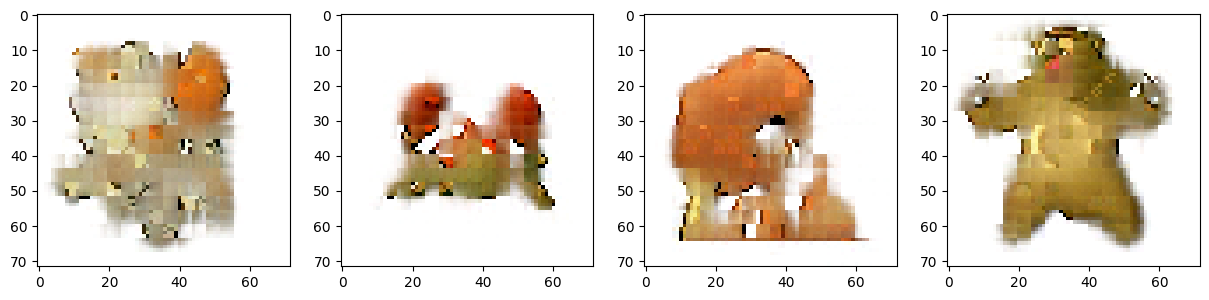

 66%|██████▌   | 132000/200000 [1:22:11<42:14, 26.83it/s]

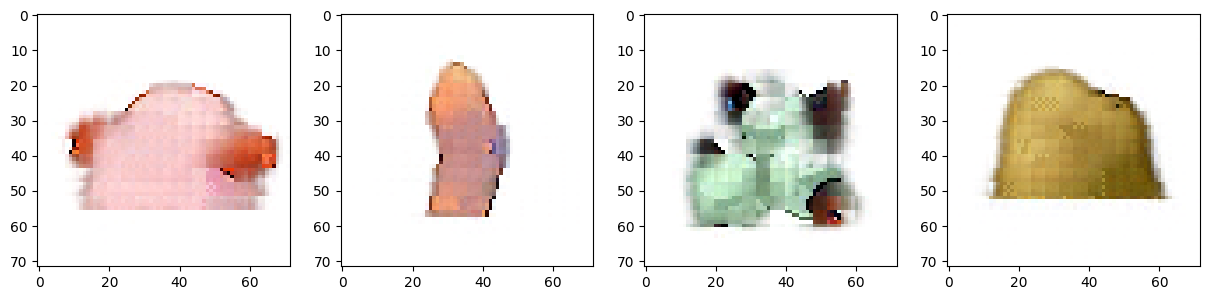

 67%|██████▋   | 134000/200000 [1:23:26<41:00, 26.83it/s]

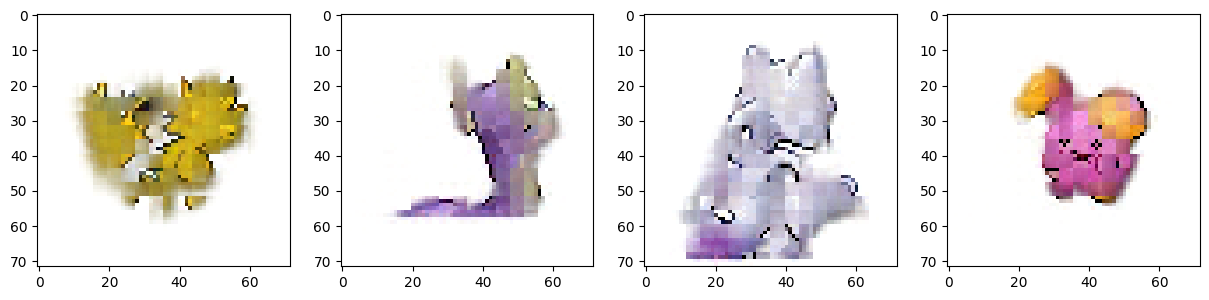

 68%|██████▊   | 136000/200000 [1:24:41<40:07, 26.59it/s]

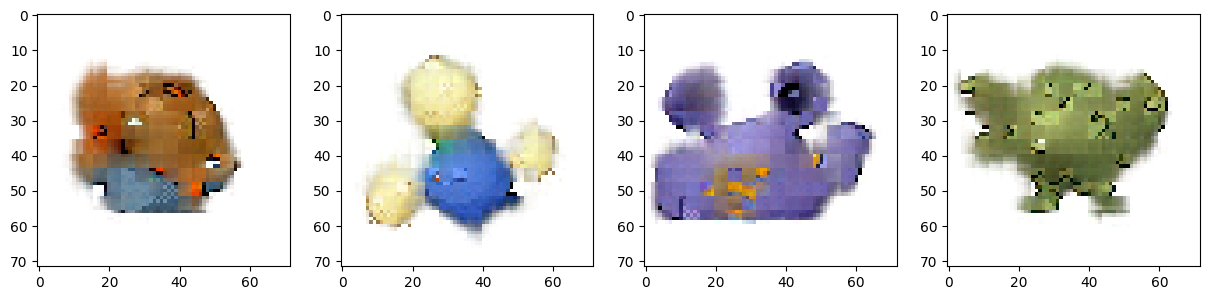

 69%|██████▉   | 138000/200000 [1:25:55<38:31, 26.82it/s]

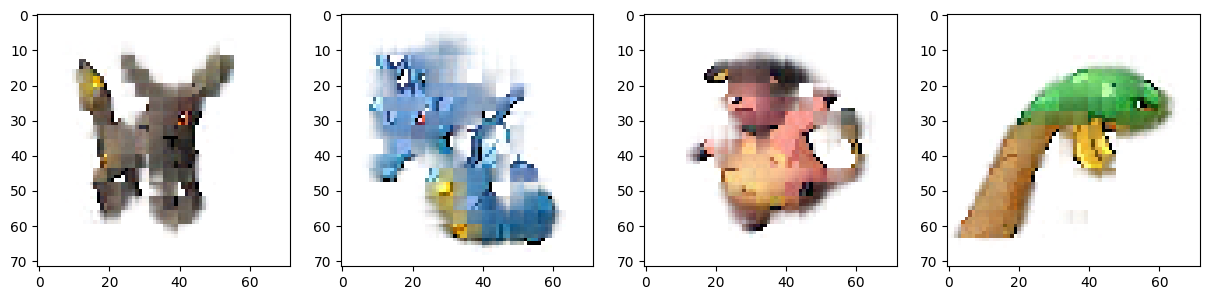

 70%|███████   | 140000/200000 [1:27:10<37:16, 26.82it/s]

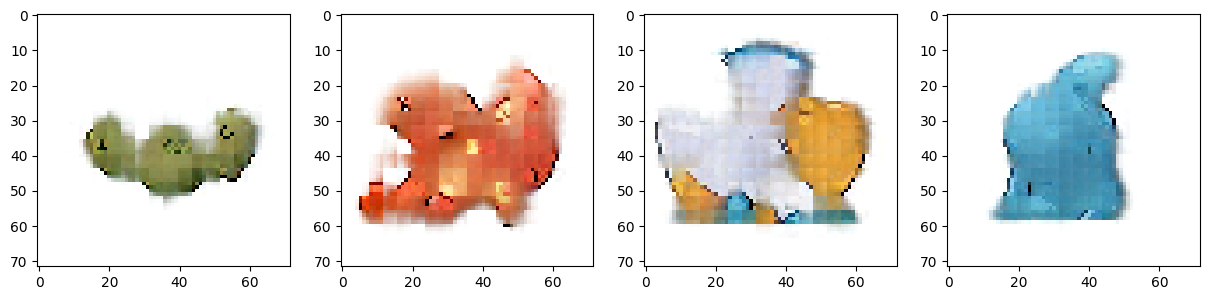

 71%|███████   | 142000/200000 [1:28:25<36:03, 26.81it/s]

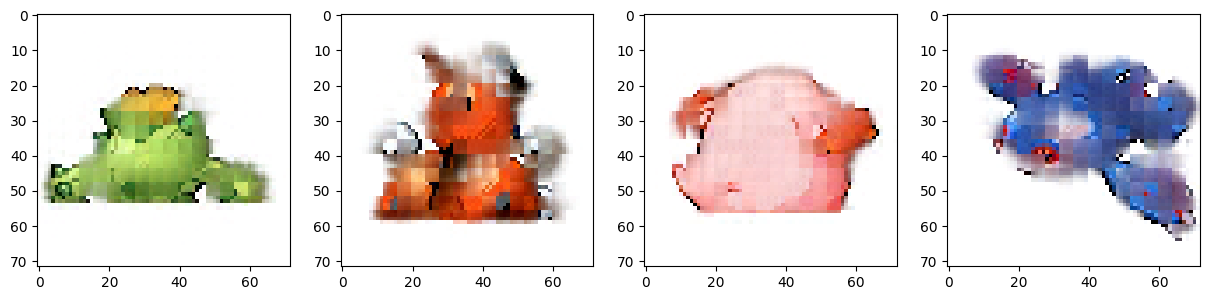

 72%|███████▏  | 144000/200000 [1:29:40<34:44, 26.86it/s]

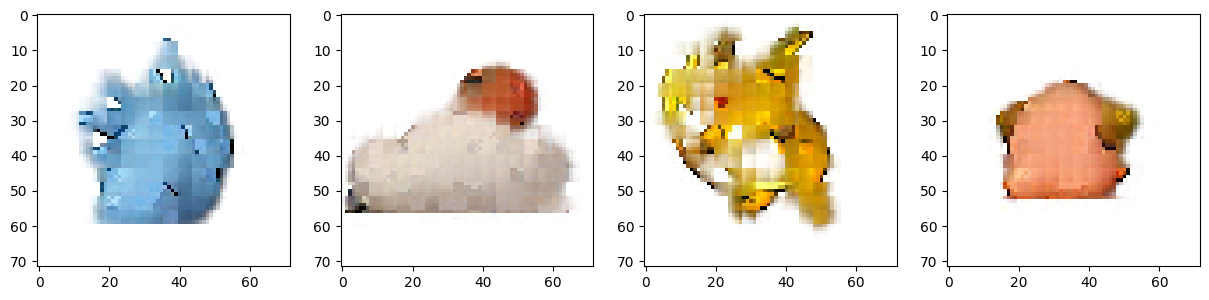

 73%|███████▎  | 146000/200000 [1:30:54<33:32, 26.83it/s]

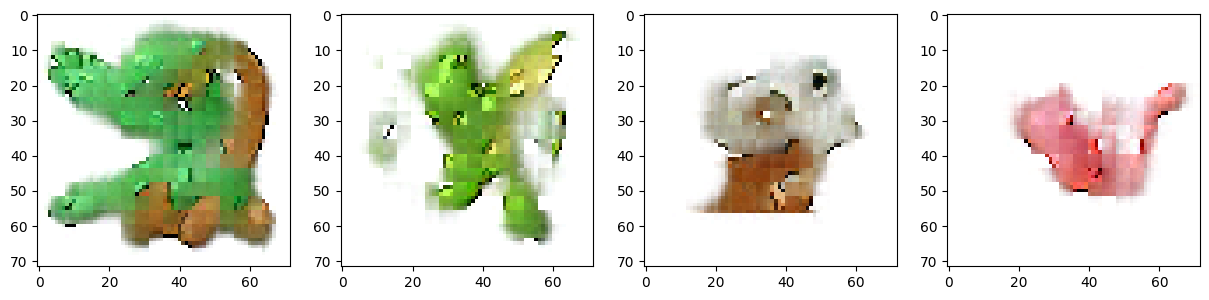

 74%|███████▍  | 148000/200000 [1:32:09<32:17, 26.84it/s]

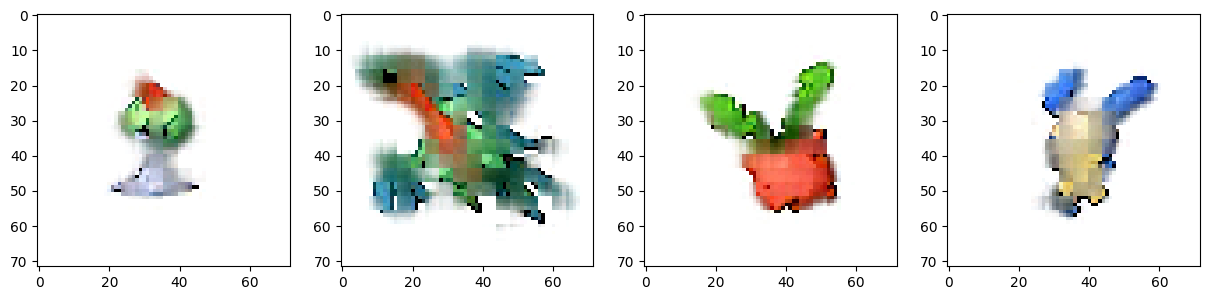

 75%|███████▌  | 150000/200000 [1:33:24<31:18, 26.61it/s]

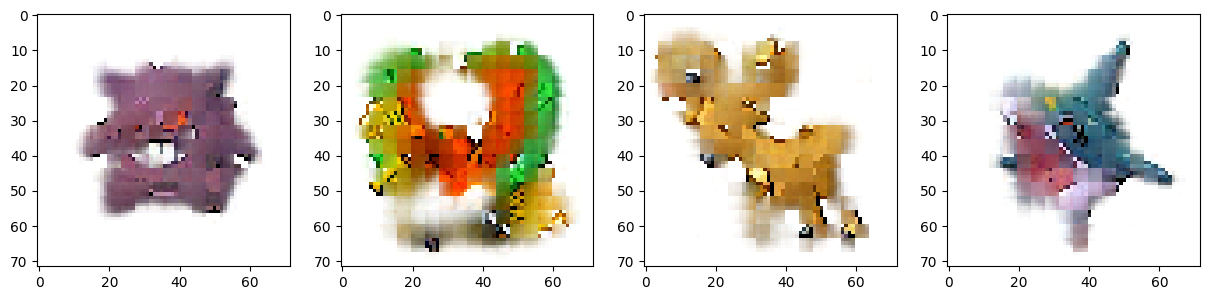

 76%|███████▌  | 152000/200000 [1:34:39<29:49, 26.83it/s]

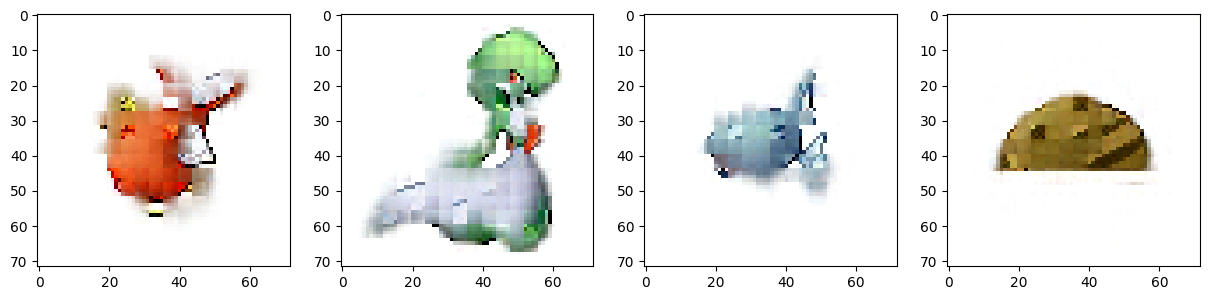

 77%|███████▋  | 154000/200000 [1:35:56<34:10, 22.44it/s]

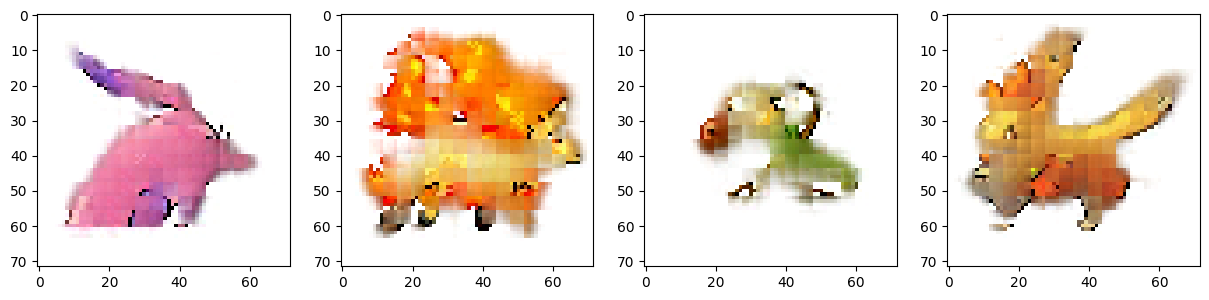

 78%|███████▊  | 156000/200000 [1:37:16<33:41, 21.76it/s]

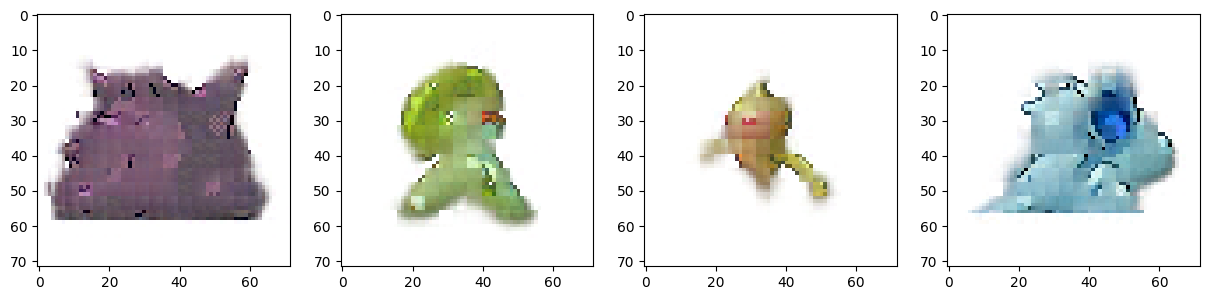

 79%|███████▉  | 158000/200000 [1:38:33<26:34, 26.34it/s]

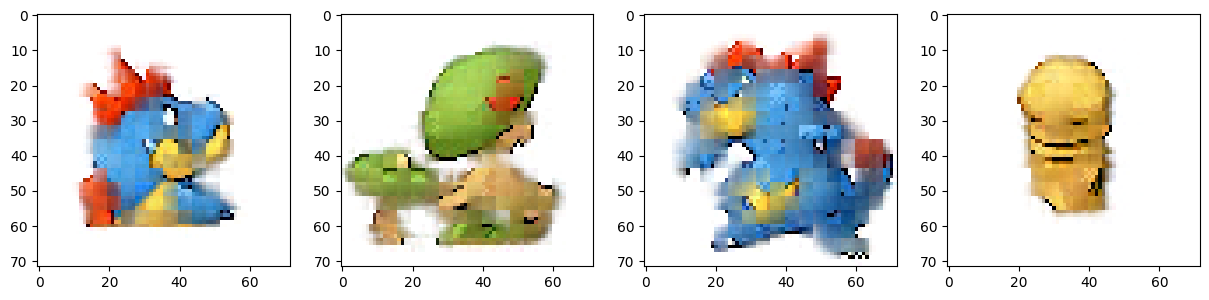

 80%|████████  | 160000/200000 [1:39:49<25:19, 26.33it/s]

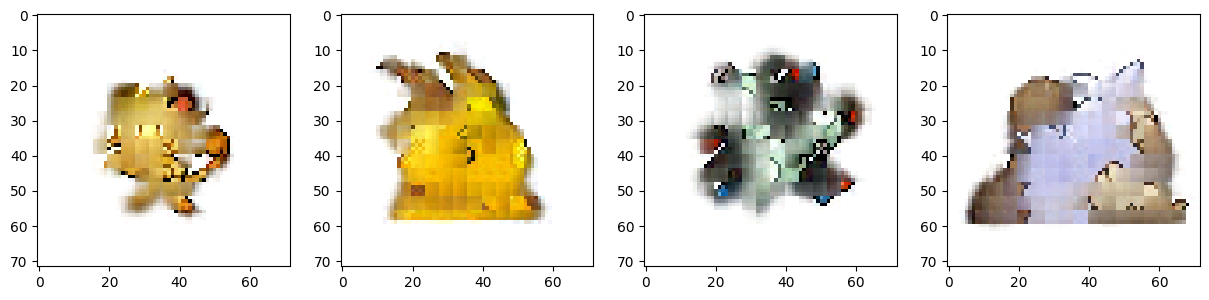

 81%|████████  | 162000/200000 [1:41:05<23:57, 26.43it/s]

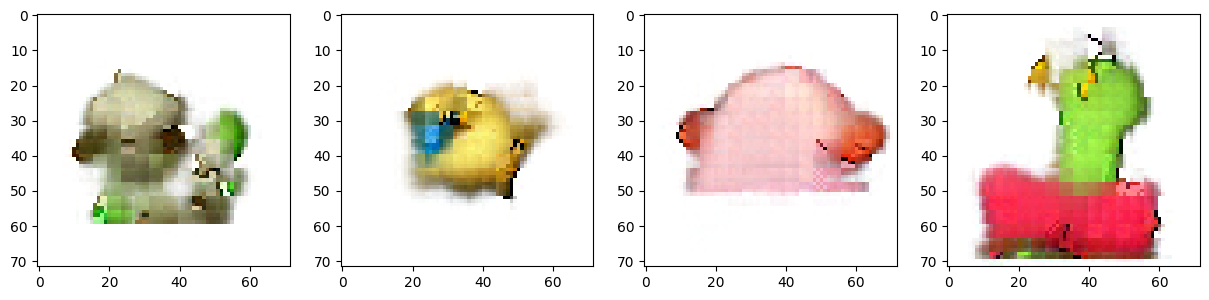

 82%|████████▏ | 164000/200000 [1:42:21<22:43, 26.41it/s]

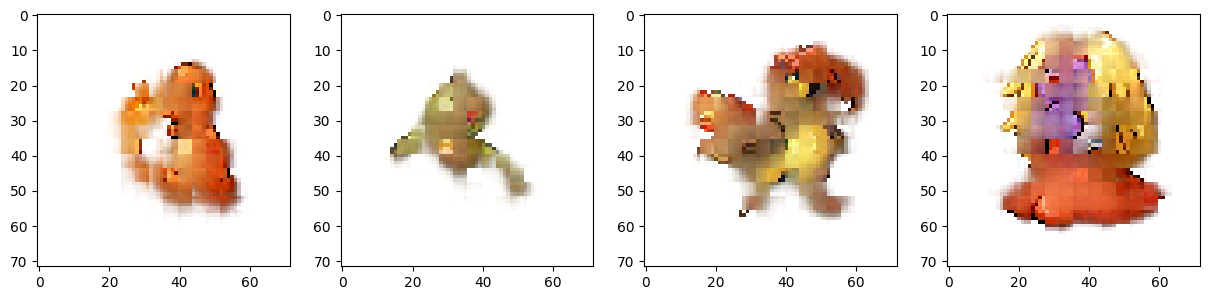

 83%|████████▎ | 166000/200000 [1:43:37<21:28, 26.40it/s]

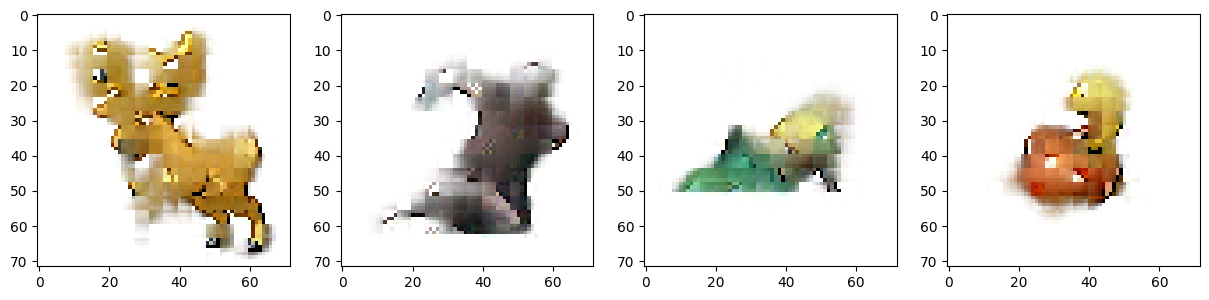

 84%|████████▍ | 168000/200000 [1:44:53<20:11, 26.41it/s]

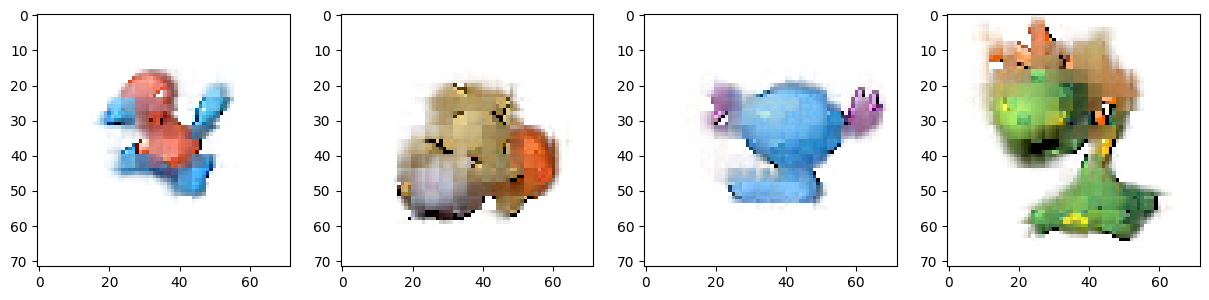

 85%|████████▌ | 170000/200000 [1:46:09<18:54, 26.44it/s]

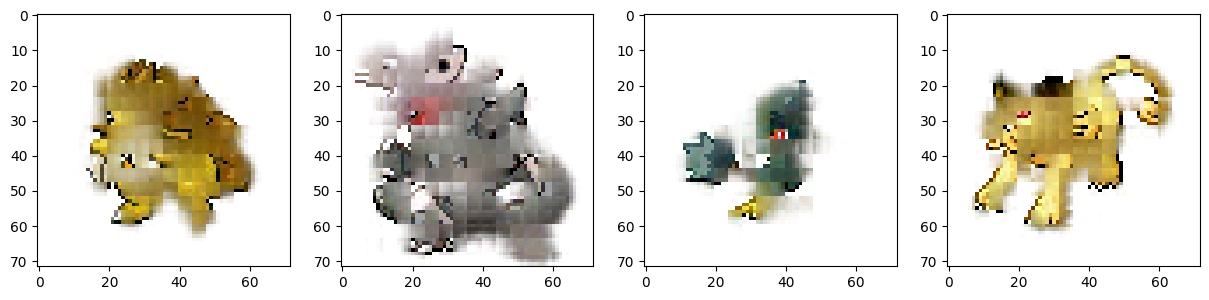

 86%|████████▌ | 172000/200000 [1:47:25<17:38, 26.46it/s]

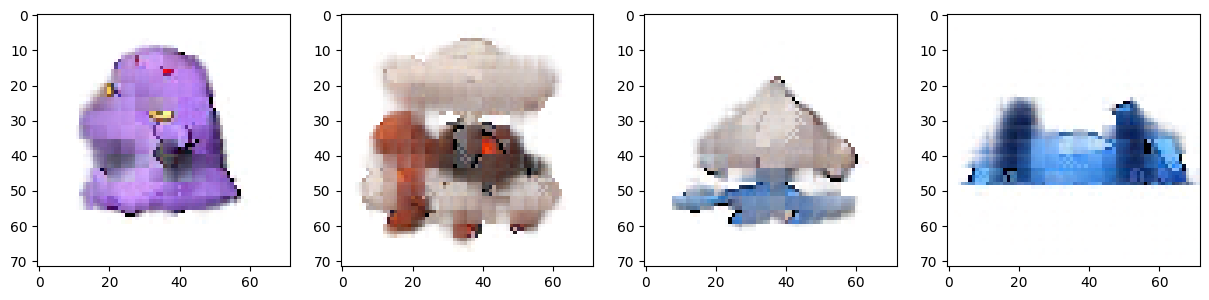

 87%|████████▋ | 174000/200000 [1:48:41<16:25, 26.38it/s]

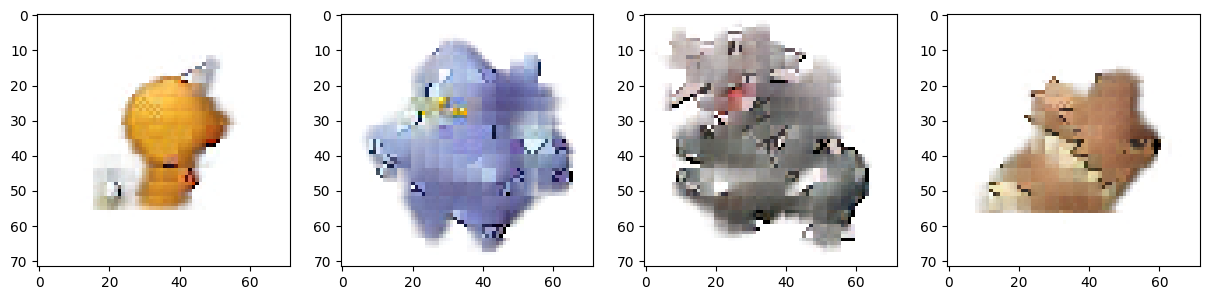

 88%|████████▊ | 176000/200000 [1:49:56<15:07, 26.45it/s]

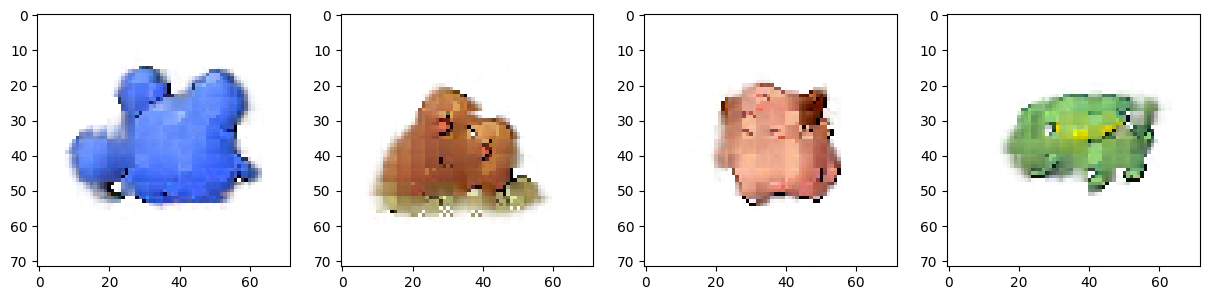

 89%|████████▉ | 178000/200000 [1:51:12<13:53, 26.38it/s]

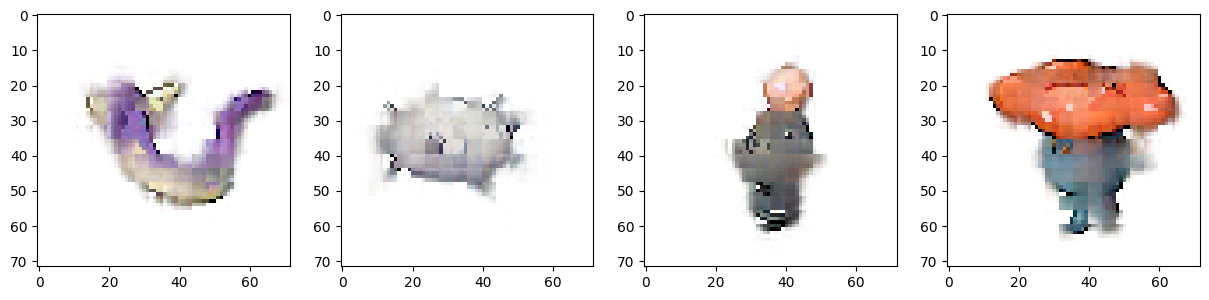

 90%|█████████ | 180000/200000 [1:52:28<12:37, 26.39it/s]

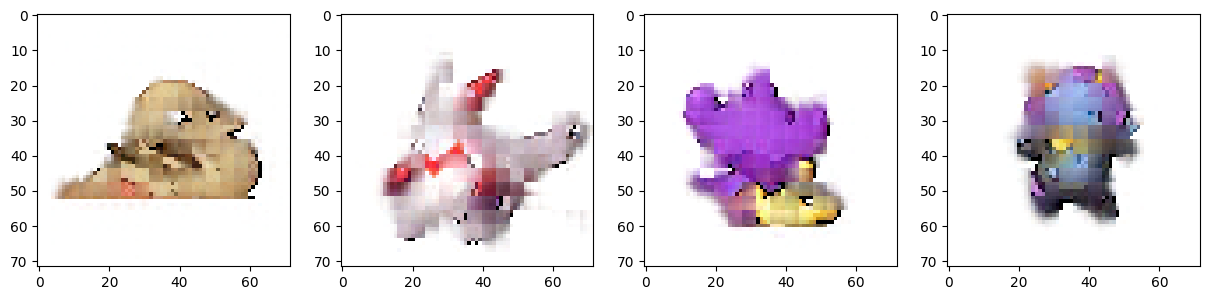

 91%|█████████ | 182000/200000 [1:53:44<11:12, 26.77it/s]

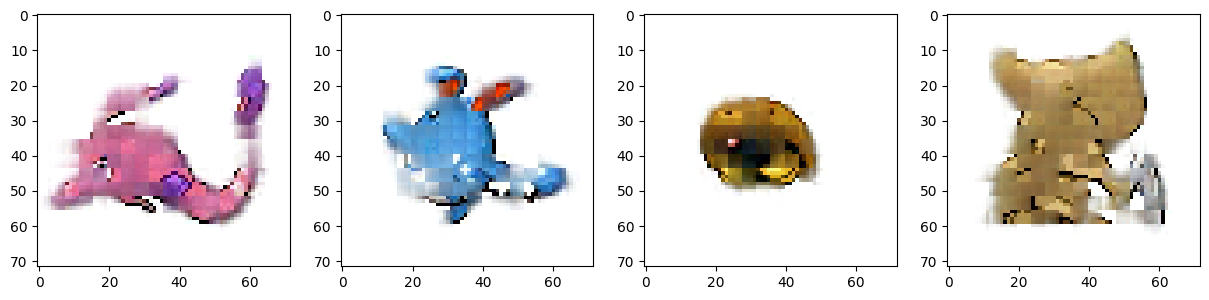

 92%|█████████▏| 184000/200000 [1:55:03<10:04, 26.49it/s]

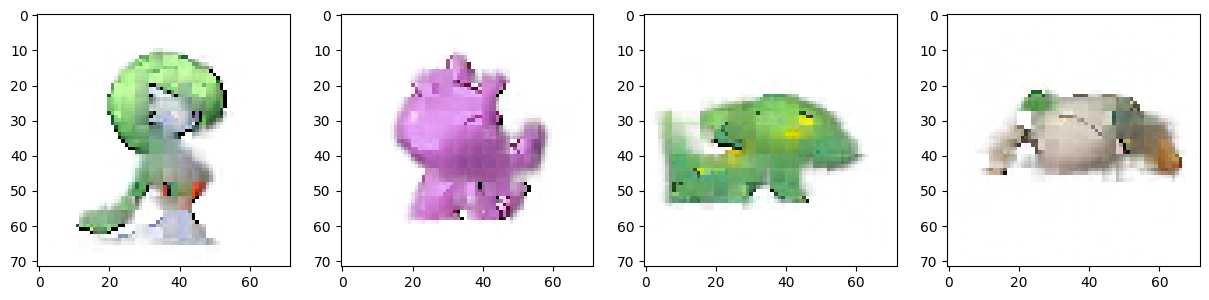

 93%|█████████▎| 186000/200000 [1:56:19<08:50, 26.37it/s]

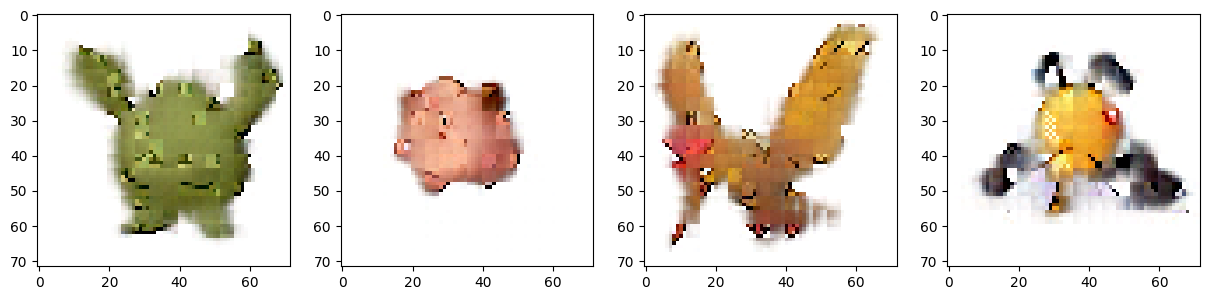

 94%|█████████▍| 188000/200000 [1:57:35<07:34, 26.41it/s]

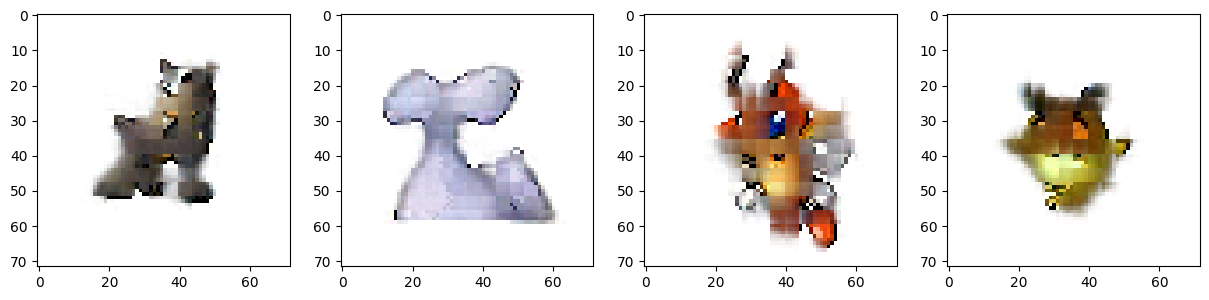

 95%|█████████▌| 190000/200000 [1:58:51<06:18, 26.42it/s]

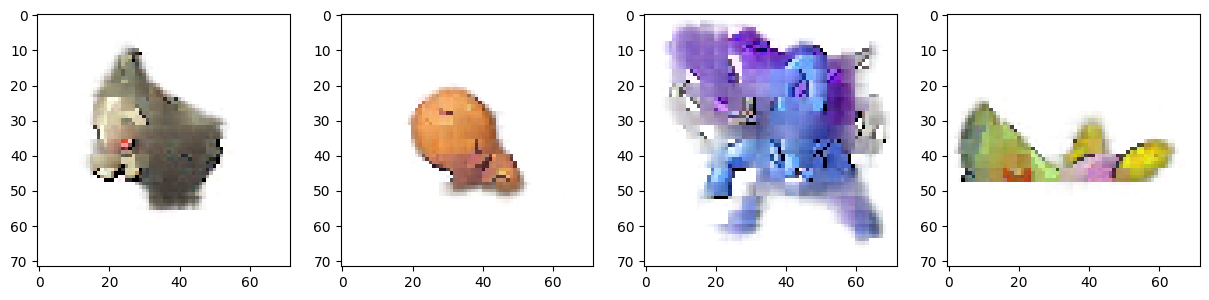

 96%|█████████▌| 192000/200000 [2:00:07<05:03, 26.40it/s]

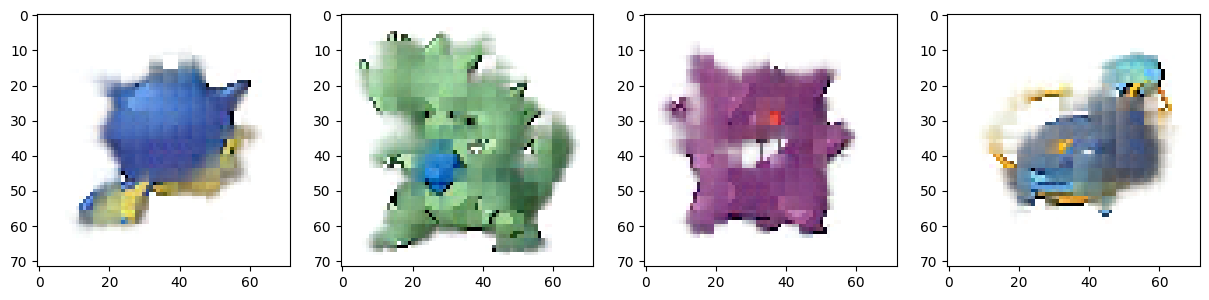

 97%|█████████▋| 194000/200000 [2:01:22<03:46, 26.44it/s]

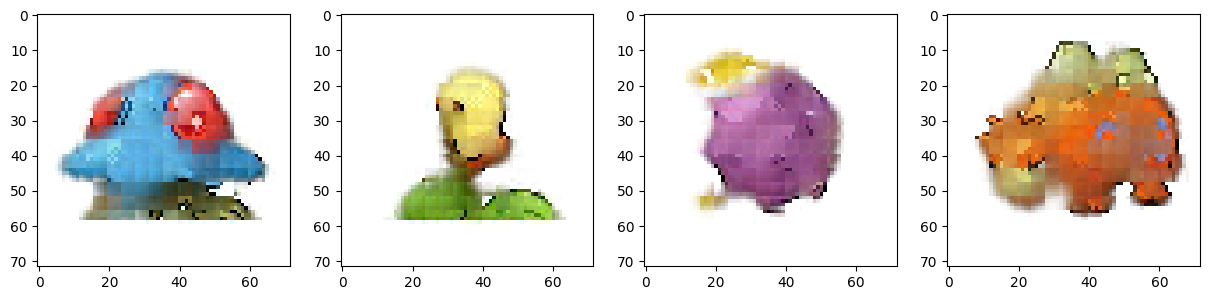

 98%|█████████▊| 196000/200000 [2:02:38<02:31, 26.41it/s]

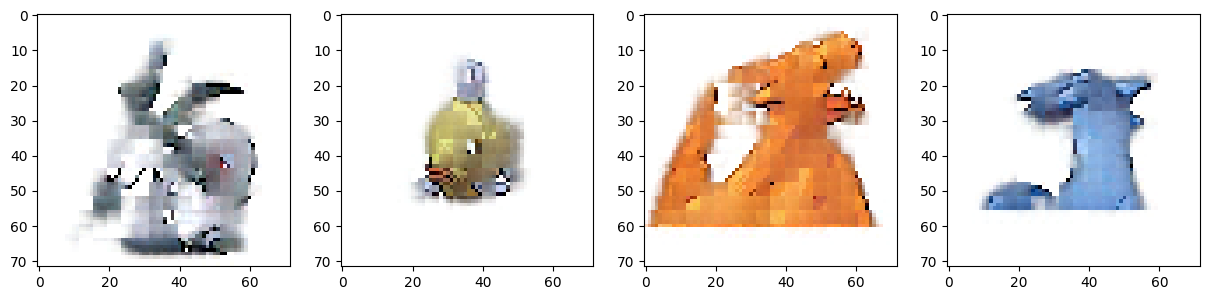

 99%|█████████▉| 198000/200000 [2:03:54<01:15, 26.49it/s]

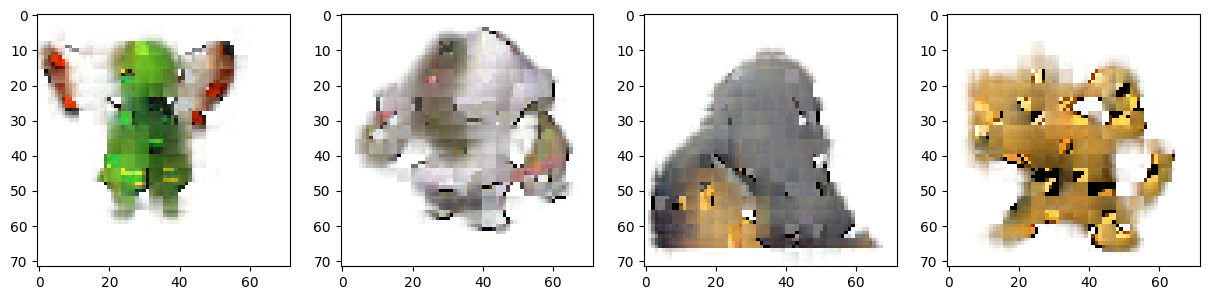

100%|██████████| 200000/200000 [2:05:10<00:00, 26.63it/s]


In [5]:
model = MyMAE(72, 4, 128).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
mse_loss = nn.MSELoss()

def train():

    for i in tqdm(range(200000), miniters=10):
        bs = 64
        source = torch.randint(0, 5, (bs,))
        batch = torch.randperm(385)[:bs]
        x0 = pimages[source, batch]
        x0 = torch.stack([pos_transform(x) for x in x0], dim=0)

        optimizer.zero_grad()

        reconstruction = model(x0)
        loss = mse_loss(reconstruction, x0) + 1.0 * ssim_loss(reconstruction, x0).mean()

        loss.backward()
        optimizer.step()

        if i % 2000 == 0:
            fig, axes = plt.subplots(1, 4, figsize=(15, 15))
            plot_image(reconstruction[0], axes[0])
            plot_image(reconstruction[1], axes[1])
            plot_image(reconstruction[2], axes[2])
            plot_image(reconstruction[3], axes[3])
            plt.show()

model.train()
train()


In [6]:
torch.save(model.state_dict(), 'mae_model.pt') #overfit?